### Import Libraries

In [2]:
import os
import librosa
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import IPython
from IPython.display import display
import torch.nn as nn
import torchaudio
import torch
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import pickle
import warnings

warnings.filterwarnings("ignore")

### Module reloading

In [3]:
import importlib
from dl import train_test_split as tts, datasets, train, prediction_plotting
from dl.models import audio_features_cnn, audio_features_nn, melgram_cnn

importlib.reload(tts)
importlib.reload(datasets)
importlib.reload(train)
importlib.reload(prediction_plotting)

importlib.reload(audio_features_cnn)
importlib.reload(audio_features_nn)
importlib.reload(melgram_cnn)

<module 'dl.models.melgram_cnn' from 'c:\\Users\\AnnaKoutougera\\Desktop\\DeepFake-Voice-Recognition\\dl\\models\\melgram_cnn.py'>

### Constants

In [4]:
# TODO: Ask if choice of target_sample_rate, segment_length and batch size is okay
audio_dir = "./AUDIO/"
demostration_dir = "./DEMONSTRATION/"
segment_length = 3  # 3 to 5 seconds is a good range for speech processing
target_sample_rate = 16000  # 16000 Hz is a standard sample rate for speech processing. Another common value is 22050 Hz. We can also try 8000
noise_threshold = 0.005  # Threshold for detecting noise NOT NEEDED
clean_audio_dir = "./CLEAN_AUDIO/"  # Directory to save cleaned audio files
output_file_dataset = "./classic_dataset.csv"  # File to save the dataset
output_file_dataset_augmented = (
    "./classic_dataset_augmented.csv"  # File to save the augmented dataset
)
output_file_images = "./annotations_images.csv"  # File to save the images annotations
output_file_images_augmented = "./annotations_images_augmented.csv"  # File to save the augmented images annotations
batch_size = 32
testing_samples = ["ryan", "margot"]

### Read necessary files

In [14]:
image_annotations = pd.read_csv(output_file_images_augmented)
classic_df = pd.read_csv(output_file_dataset_augmented)
img_dir = "./mel_spectograms_augmented/"
saved_models_dir = "./saved_models_augmented/"
# make sure the directory exists
os.makedirs(saved_models_dir, exist_ok=True)
input_dim = 26  # 26 features in x
output_dim = 1  # 1 output

### Set device

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

Using device cuda


### Modelling data

Images

In [8]:
image_annotations_train, image_annotations_val, image_annotations_test = (
    tts.train_test_split_dataset(
        image_annotations,
        testing_samples=testing_samples,
        val_size=0.1,
        random_state=42,
        tag="image",
    )
)
# Define the label mapping
label_mapping = {"REAL": 1, "FAKE": 0}

# Create the target transform using the label mapping
target_transform = lambda x: label_mapping[x]

# Create an instance of the CustomImageDataset
training_image_data = datasets.CustomPickleDataset(
    image_annotations_train, img_dir, target_transform, device=device
)
validation_image_data = datasets.CustomPickleDataset(
    image_annotations_val, img_dir, target_transform, device=device
)
testing_image_data = datasets.CustomPickleDataset(
    image_annotations_test, img_dir, target_transform, device=device
)

# Create DataLoaders for the data
train_image_dataloader = DataLoader(
    training_image_data, batch_size=batch_size, shuffle=True
)
val_image_dataloader = DataLoader(
    validation_image_data, batch_size=batch_size, shuffle=True
)
test_image_dataloader = DataLoader(
    testing_image_data, batch_size=batch_size, shuffle=True
)

Classic Dataset

In [9]:
classic_df_train, classic_df_val, classic_df_test = tts.train_test_split_dataset(
    classic_df,
    testing_samples=testing_samples,
    val_size=0.1,
    random_state=42,
    tag="tabular",
)


# Define the label mapping
label_mapping = {"REAL": 1, "FAKE": 0}
# Create the target transform using the label mapping
target_transform = lambda x: label_mapping[x]


cnn_training_data = datasets.CustomClassicDataset(
    classic_df_train, target_transform=target_transform, device=device, tag="cnn"
)
cnn_validation_data = datasets.CustomClassicDataset(
    classic_df_val, target_transform=target_transform, device=device, tag="cnn"
)
cnn_testing_data = datasets.CustomClassicDataset(
    classic_df_test, target_transform=target_transform, device=device, tag="cnn"
)


# Create DataLoaders for the data
train_cnn_dataloader = DataLoader(
    cnn_training_data, batch_size=batch_size, shuffle=True
)
val_cnn_dataloader = DataLoader(
    cnn_validation_data, batch_size=batch_size, shuffle=True
)
test_cnn_dataloader = DataLoader(cnn_testing_data, batch_size=batch_size, shuffle=True)

nn_training_data = datasets.CustomClassicDataset(
    classic_df_train, target_transform=target_transform, device=device, tag="nn"
)
nn_validation_data = datasets.CustomClassicDataset(
    classic_df_val, target_transform=target_transform, device=device, tag="nn"
)
nn_testing_data = datasets.CustomClassicDataset(
    classic_df_test, target_transform=target_transform, device=device, tag="nn"
)


# Create DataLoaders for the data
train_nn_dataloader = DataLoader(nn_training_data, batch_size=batch_size, shuffle=True)
val_nn_dataloader = DataLoader(nn_validation_data, batch_size=batch_size, shuffle=True)
test_nn_dataloader = DataLoader(nn_testing_data, batch_size=batch_size, shuffle=True)

## Models

### With Audio Features

#### NN

In [29]:
# Define model
model = audio_features_nn.AudioFeatureNN1(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 26]             702
              ReLU-2                [-1, 1, 26]               0
            Linear-3                [-1, 1, 26]             702
              ReLU-4                [-1, 1, 26]               0
            Linear-5                [-1, 1, 26]             702
              ReLU-6                [-1, 1, 26]               0
            Linear-7                [-1, 1, 26]             702
              ReLU-8                [-1, 1, 26]               0
            Linear-9                [-1, 1, 26]             702
             ReLU-10                [-1, 1, 26]               0
           Linear-11                 [-1, 1, 1]              27
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 3,537
Trainable params: 3,537
Non-trainable params: 0
-----------------------------------

Epoch 1/70, Train Loss: 0.8584, Train Acc: 0.2726, Val Loss: 0.8027, Val Acc: 0.3744, Val Precision: 0.2435, Val Recall: 0.8613, Val F1: 0.3796
Model saved at epoch 1
Epoch 2/70, Train Loss: 0.7972, Train Acc: 0.4787, Val Loss: 0.7887, Val Acc: 0.5266, Val Precision: 0.2701, Val Recall: 0.6639, Val F1: 0.3840
Model saved at epoch 2
Epoch 3/70, Train Loss: 0.7915, Train Acc: 0.4841, Val Loss: 0.7830, Val Acc: 0.5668, Val Precision: 0.2892, Val Recall: 0.6513, Val F1: 0.4005
Model saved at epoch 3
Epoch 4/70, Train Loss: 0.7879, Train Acc: 0.5063, Val Loss: 0.7815, Val Acc: 0.6004, Val Precision: 0.2944, Val Recall: 0.5714, Val F1: 0.3886
Epoch 5/70, Train Loss: 0.7858, Train Acc: 0.5715, Val Loss: 0.7784, Val Acc: 0.6172, Val Precision: 0.3193, Val Recall: 0.6387, Val F1: 0.4258
Model saved at epoch 5
Epoch 6/70, Train Loss: 0.7841, Train Acc: 0.5904, Val Loss: 0.7792, Val Acc: 0.5705, Val Precision: 0.3112, Val Recall: 0.7689, Val F1: 0.4431
Model saved at epoch 6
Epoch 7/70, Train Los

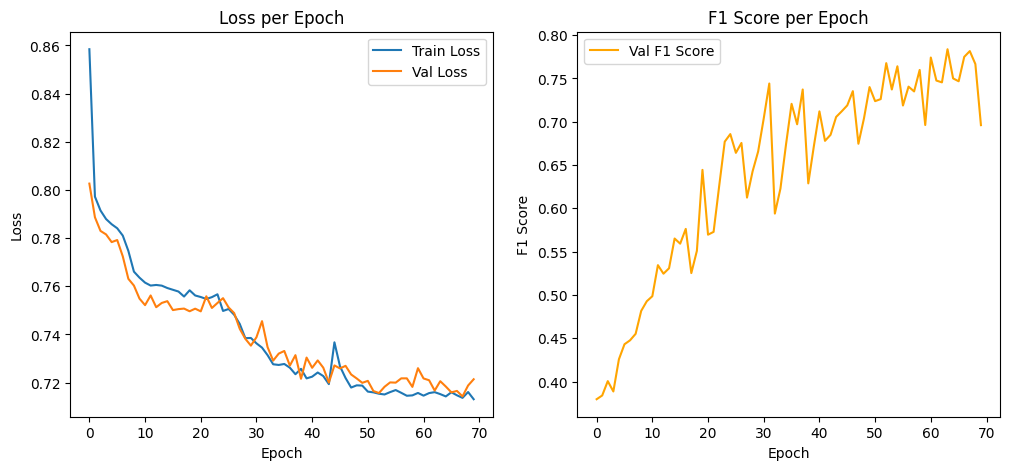

In [30]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=70,
    save_path=os.path.join(saved_models_dir, "nn1_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL    ryan-to-obama: FAKE
margot-original: REAL  margot-to-trump: FAKE
                         ryan-to-trump: FAKE
                      margot-to-taylor: FAKE
                       margot-to-linus: FAKE
                         ryan-to-biden: FAKE
                        margot-to-ryan: FAKE
                        ryan-to-margot: FAKE
                        margot-to-musk: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-taylor: FAKE
                       margot-to-biden: FAKE
                          ryan-to-musk: FAKE
                       margot-to-obama: FAKE


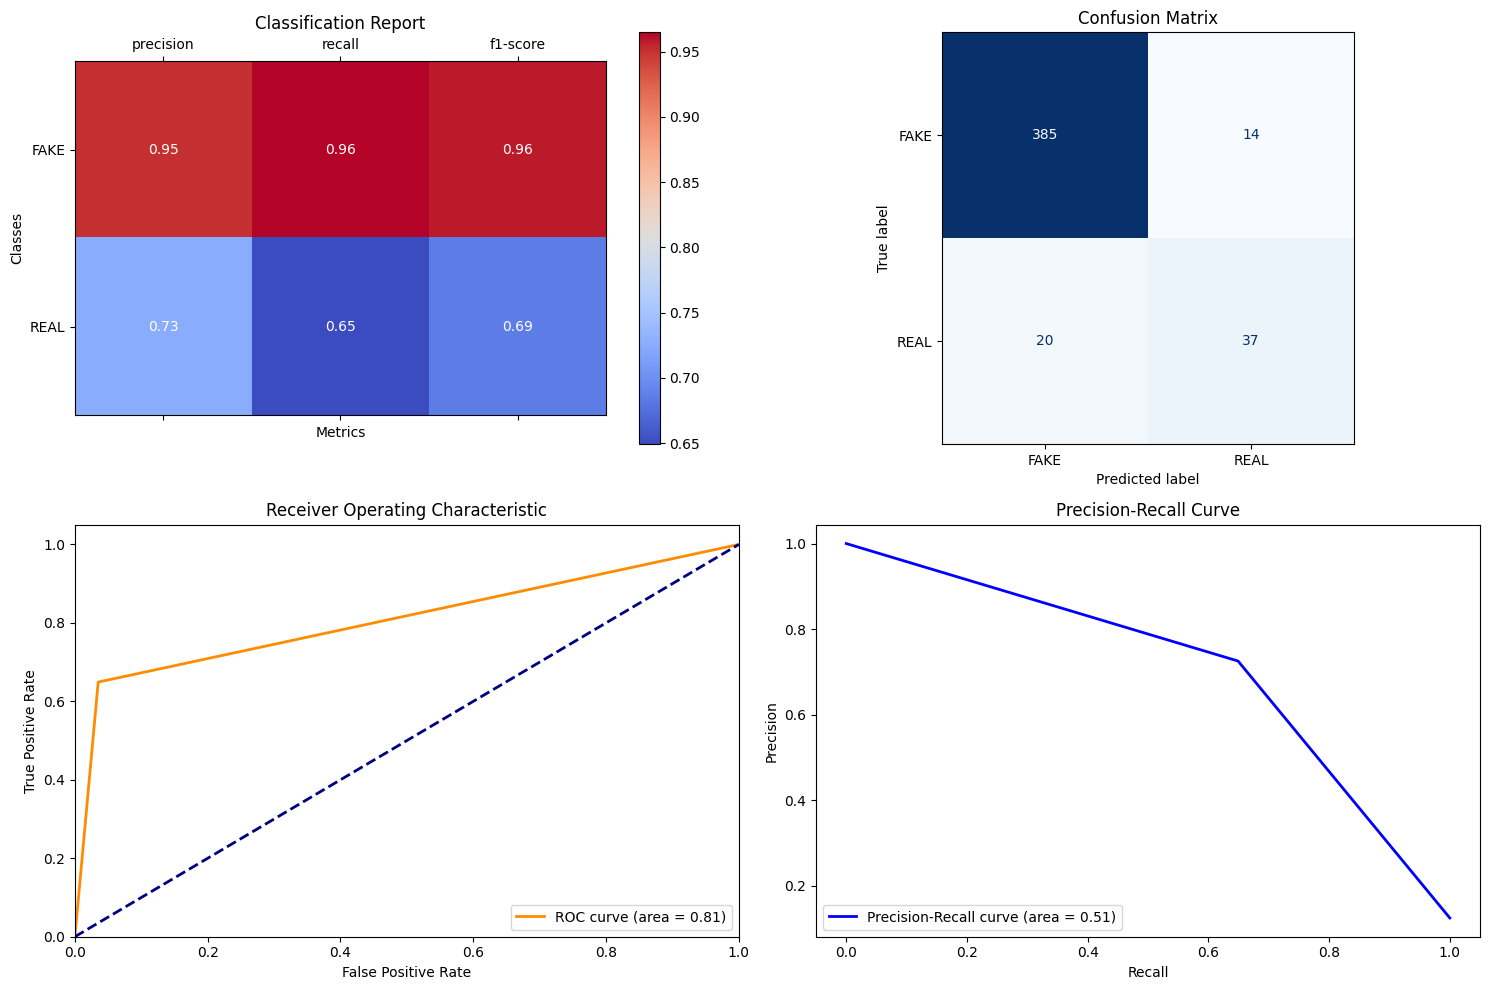

In [31]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn1_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [32]:
# Define model
model = audio_features_nn.AudioFeatureNN2(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 52]           1,404
              ReLU-2                [-1, 1, 52]               0
           Dropout-3                [-1, 1, 52]               0
            Linear-4               [-1, 1, 104]           5,512
              ReLU-5               [-1, 1, 104]               0
           Dropout-6               [-1, 1, 104]               0
            Linear-7                [-1, 1, 52]           5,460
              ReLU-8                [-1, 1, 52]               0
           Dropout-9                [-1, 1, 52]               0
           Linear-10                [-1, 1, 26]           1,378
             ReLU-11                [-1, 1, 26]               0
          Dropout-12                [-1, 1, 26]               0
           Linear-13                 [-1, 1, 1]              27
          Sigmoid-14                 [-

Epoch 1/60, Train Loss: 0.9701, Train Acc: 0.2881, Val Loss: 0.9122, Val Acc: 0.3978, Val Precision: 0.2674, Val Recall: 0.9832, Val F1: 0.4205
Model saved at epoch 1
Epoch 2/60, Train Loss: 0.9058, Train Acc: 0.3855, Val Loss: 0.8649, Val Acc: 0.4725, Val Precision: 0.2928, Val Recall: 0.9706, Val F1: 0.4499
Model saved at epoch 2
Epoch 3/60, Train Loss: 0.8720, Train Acc: 0.4769, Val Loss: 0.8516, Val Acc: 0.5724, Val Precision: 0.3373, Val Recall: 0.9580, Val F1: 0.4989
Model saved at epoch 3
Epoch 4/60, Train Loss: 0.8636, Train Acc: 0.5126, Val Loss: 0.8394, Val Acc: 0.5630, Val Precision: 0.3333, Val Recall: 0.9664, Val F1: 0.4957
Epoch 5/60, Train Loss: 0.8508, Train Acc: 0.5655, Val Loss: 0.8309, Val Acc: 0.6415, Val Precision: 0.3759, Val Recall: 0.9286, Val F1: 0.5351
Model saved at epoch 5
Epoch 6/60, Train Loss: 0.8499, Train Acc: 0.5984, Val Loss: 0.8302, Val Acc: 0.6415, Val Precision: 0.3791, Val Recall: 0.9622, Val F1: 0.5439
Model saved at epoch 6
Epoch 7/60, Train Los

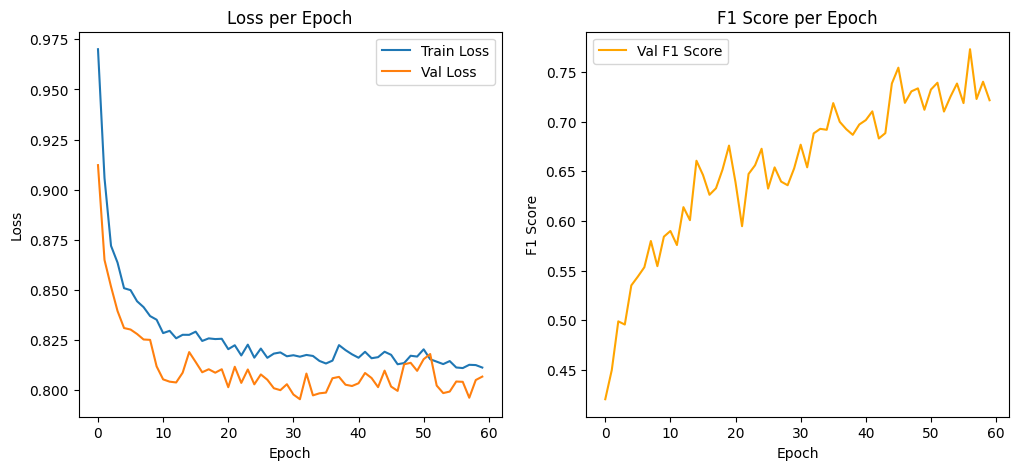

In [33]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 3.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=60,
    save_path=os.path.join(saved_models_dir, "nn2_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE  margot-to-obama: FAKE
  ryan-original: REAL   ryan-to-margot: FAKE
                         ryan-to-linus: FAKE
                       margot-to-linus: FAKE
                       margot-to-biden: FAKE
                          ryan-to-musk: FAKE
                        margot-to-ryan: FAKE
                       margot-to-trump: FAKE
                      margot-to-taylor: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-biden: FAKE
                         ryan-to-obama: FAKE
                        margot-to-musk: FAKE
                         ryan-to-trump: FAKE


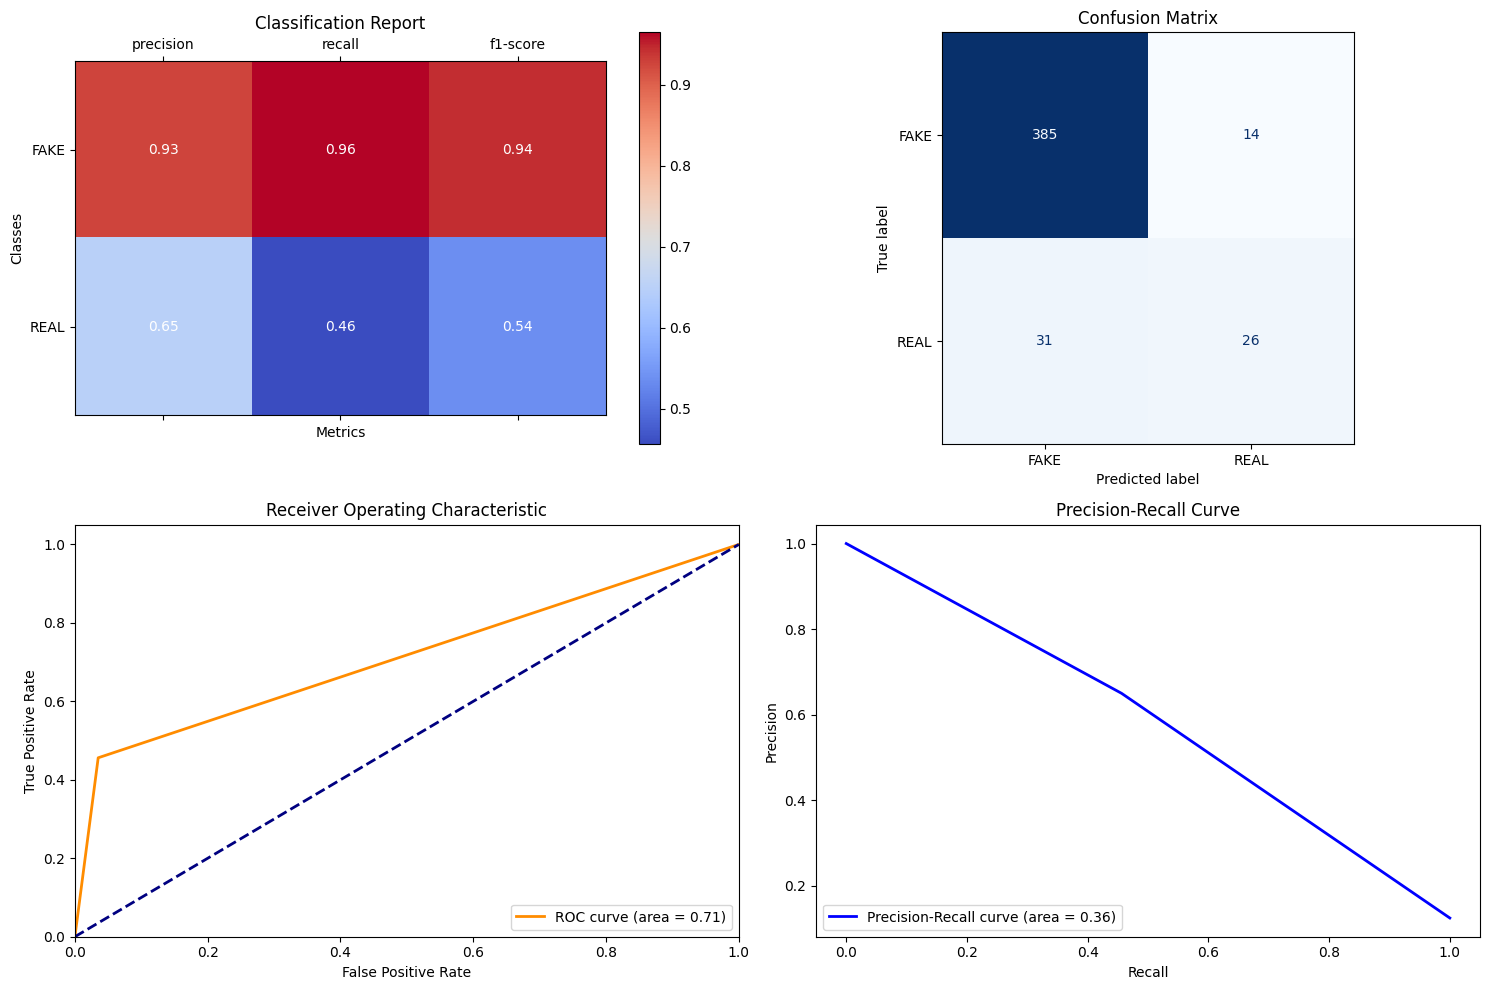

In [34]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn2_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [44]:
# Define model
model = audio_features_nn.AudioFeatureNN1(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 26]             702
              ReLU-2                [-1, 1, 26]               0
            Linear-3                [-1, 1, 26]             702
              ReLU-4                [-1, 1, 26]               0
            Linear-5                [-1, 1, 26]             702
              ReLU-6                [-1, 1, 26]               0
            Linear-7                [-1, 1, 26]             702
              ReLU-8                [-1, 1, 26]               0
            Linear-9                [-1, 1, 26]             702
             ReLU-10                [-1, 1, 26]               0
           Linear-11                 [-1, 1, 1]              27
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 3,537
Trainable params: 3,537
Non-trainable params: 0
-----------------------------------

Epoch 1/100, Train Loss: 0.8471, Train Acc: 0.2768, Val Loss: 0.7997, Val Acc: 0.3744, Val Precision: 0.2488, Val Recall: 0.8992, Val F1: 0.3898
Model saved at epoch 1
Epoch 2/100, Train Loss: 0.7989, Train Acc: 0.3880, Val Loss: 0.7915, Val Acc: 0.4136, Val Precision: 0.2673, Val Recall: 0.9412, Val F1: 0.4164
Model saved at epoch 2
Epoch 3/100, Train Loss: 0.7886, Train Acc: 0.4402, Val Loss: 0.7784, Val Acc: 0.4809, Val Precision: 0.2729, Val Recall: 0.8025, Val F1: 0.4072
Epoch 4/100, Train Loss: 0.7829, Train Acc: 0.5075, Val Loss: 0.7755, Val Acc: 0.6265, Val Precision: 0.3494, Val Recall: 0.7899, Val F1: 0.4845
Model saved at epoch 4
Epoch 5/100, Train Loss: 0.7812, Train Acc: 0.5580, Val Loss: 0.7715, Val Acc: 0.5537, Val Precision: 0.3052, Val Recall: 0.7899, Val F1: 0.4403
Epoch 6/100, Train Loss: 0.7790, Train Acc: 0.5609, Val Loss: 0.7667, Val Acc: 0.6246, Val Precision: 0.3423, Val Recall: 0.7479, Val F1: 0.4697
Epoch 7/100, Train Loss: 0.7705, Train Acc: 0.5841, Val Loss:

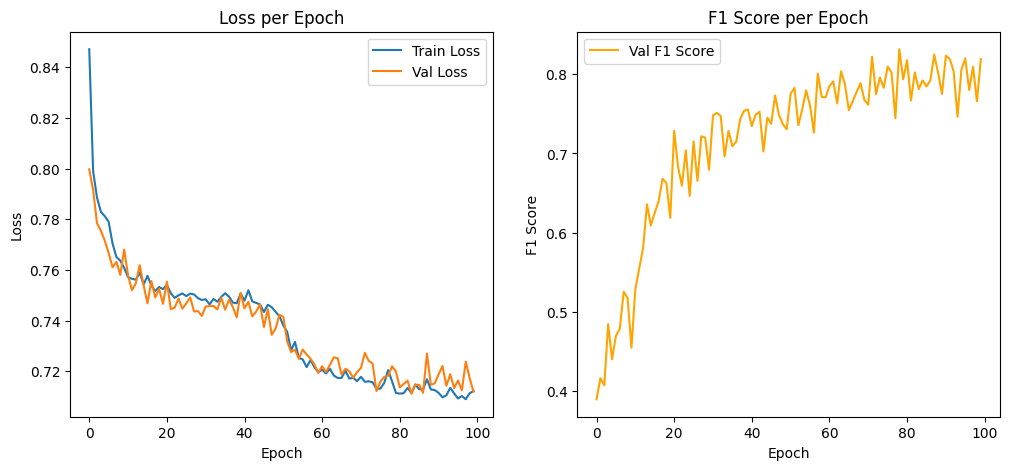

In [45]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=100,
    save_path=os.path.join(saved_models_dir, "nn3_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL   ryan-to-taylor: FAKE
margot-original: FAKE   ryan-to-margot: FAKE
                       margot-to-linus: FAKE
                          ryan-to-musk: FAKE
                        margot-to-musk: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-biden: FAKE
                         ryan-to-obama: FAKE
                       margot-to-obama: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE
                        margot-to-ryan: FAKE


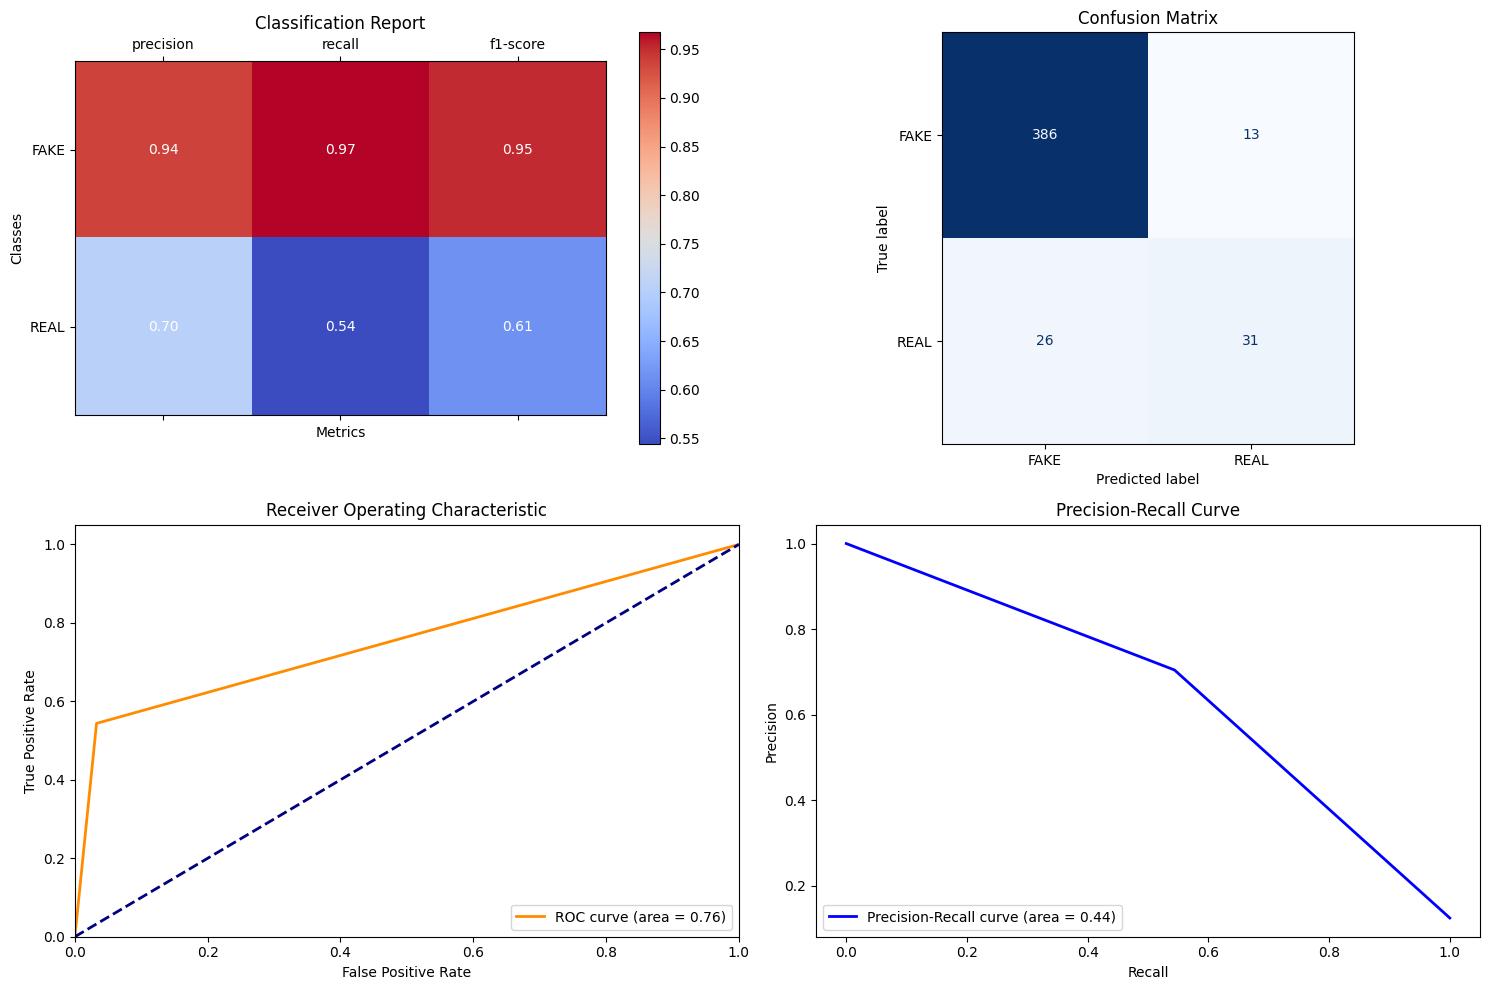

In [47]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn3_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [50]:
# Define model
model = audio_features_nn.AudioFeatureNN2(input_dim, output_dim, dropout_prob=0).to(
    device
)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 52]           1,404
              ReLU-2                [-1, 1, 52]               0
           Dropout-3                [-1, 1, 52]               0
            Linear-4               [-1, 1, 104]           5,512
              ReLU-5               [-1, 1, 104]               0
           Dropout-6               [-1, 1, 104]               0
            Linear-7                [-1, 1, 52]           5,460
              ReLU-8                [-1, 1, 52]               0
           Dropout-9                [-1, 1, 52]               0
           Linear-10                [-1, 1, 26]           1,378
             ReLU-11                [-1, 1, 26]               0
          Dropout-12                [-1, 1, 26]               0
           Linear-13                 [-1, 1, 1]              27
          Sigmoid-14                 [-

Epoch 1/70, Train Loss: 0.8284, Train Acc: 0.3199, Val Loss: 0.7994, Val Acc: 0.4650, Val Precision: 0.2670, Val Recall: 0.8067, Val F1: 0.4013
Model saved at epoch 1
Epoch 2/70, Train Loss: 0.8018, Train Acc: 0.5211, Val Loss: 0.7970, Val Acc: 0.6069, Val Precision: 0.3057, Val Recall: 0.6050, Val F1: 0.4062
Model saved at epoch 2
Epoch 3/70, Train Loss: 0.8001, Train Acc: 0.6288, Val Loss: 0.7972, Val Acc: 0.7106, Val Precision: 0.3953, Val Recall: 0.5714, Val F1: 0.4674
Model saved at epoch 3
Epoch 4/70, Train Loss: 0.7991, Train Acc: 0.6977, Val Loss: 0.7949, Val Acc: 0.7367, Val Precision: 0.4167, Val Recall: 0.4622, Val F1: 0.4382
Epoch 5/70, Train Loss: 0.7989, Train Acc: 0.7431, Val Loss: 0.7957, Val Acc: 0.7610, Val Precision: 0.4579, Val Recall: 0.4118, Val F1: 0.4336
Epoch 6/70, Train Loss: 0.7985, Train Acc: 0.7720, Val Loss: 0.7954, Val Acc: 0.7582, Val Precision: 0.4561, Val Recall: 0.4580, Val F1: 0.4570
Epoch 7/70, Train Loss: 0.7985, Train Acc: 0.7734, Val Loss: 0.7935

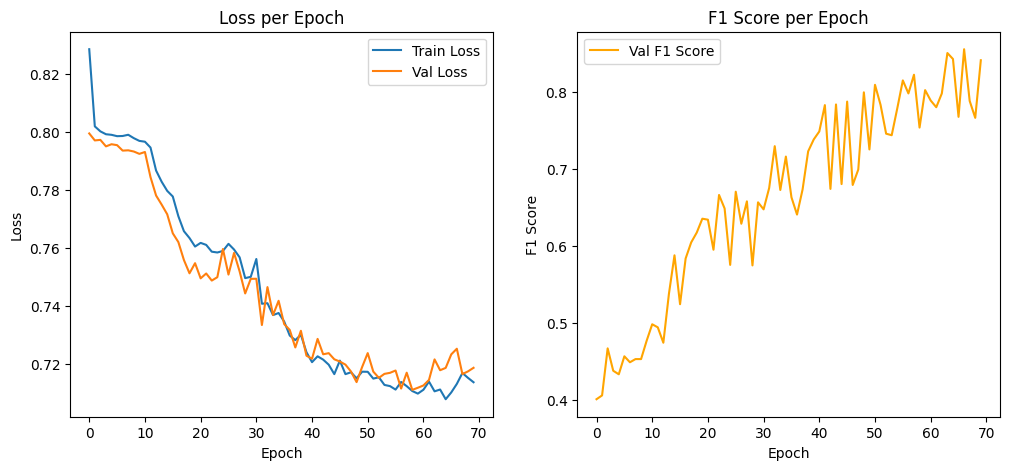

In [51]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=70,
    save_path=os.path.join(saved_models_dir, "nn4_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE  margot-to-obama: FAKE
  ryan-original: REAL  margot-to-biden: FAKE
                      margot-to-taylor: FAKE
                       margot-to-trump: FAKE
                         ryan-to-obama: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-biden: FAKE
                        ryan-to-taylor: FAKE
                          ryan-to-musk: FAKE
                        ryan-to-margot: FAKE
                       margot-to-linus: FAKE
                         ryan-to-trump: FAKE
                        margot-to-musk: FAKE
                        margot-to-ryan: FAKE


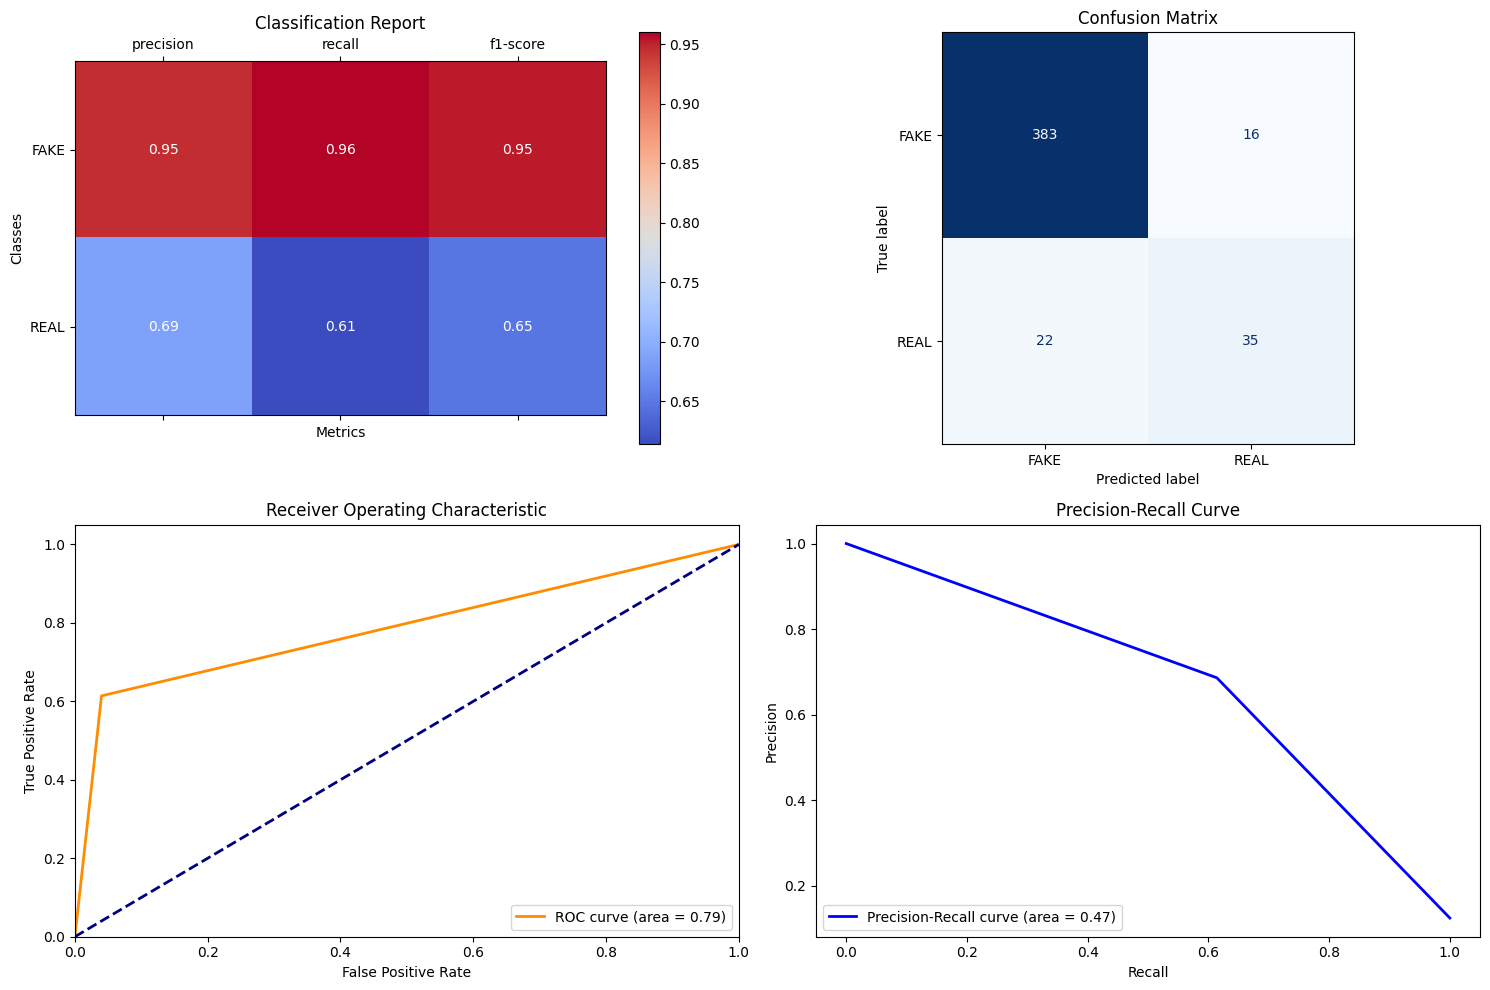

In [52]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn4_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

#### CNN

In [54]:
# Define model
model = audio_features_cnn.AudioFeatureCNN1().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 26]              64
              ReLU-2               [-1, 16, 26]               0
         MaxPool1d-3               [-1, 16, 13]               0
           Dropout-4               [-1, 16, 13]               0
            Conv1d-5               [-1, 32, 13]           1,568
              ReLU-6               [-1, 32, 13]               0
         MaxPool1d-7                [-1, 32, 6]               0
           Dropout-8                [-1, 32, 6]               0
            Conv1d-9                [-1, 64, 6]           6,208
             ReLU-10                [-1, 64, 6]               0
        MaxPool1d-11                [-1, 64, 3]               0
          Dropout-12                [-1, 64, 3]               0
          Flatten-13                  [-1, 192]               0
           Linear-14                   

Epoch 1/50, Train Loss: 0.7225, Train Acc: 0.7590, Val Loss: 0.6118, Val Acc: 0.8151, Val Precision: 0.5926, Val Recall: 0.5378, Val F1: 0.5639
Model saved at epoch 1
Epoch 2/50, Train Loss: 0.6278, Train Acc: 0.7933, Val Loss: 0.5402, Val Acc: 0.8553, Val Precision: 0.7546, Val Recall: 0.5168, Val F1: 0.6135
Model saved at epoch 2
Epoch 3/50, Train Loss: 0.5771, Train Acc: 0.8155, Val Loss: 0.5006, Val Acc: 0.8655, Val Precision: 0.7500, Val Recall: 0.5924, Val F1: 0.6620
Model saved at epoch 3
Epoch 4/50, Train Loss: 0.5372, Train Acc: 0.8252, Val Loss: 0.4546, Val Acc: 0.8590, Val Precision: 0.6629, Val Recall: 0.7437, Val F1: 0.7010
Model saved at epoch 4
Epoch 5/50, Train Loss: 0.5147, Train Acc: 0.8358, Val Loss: 0.4223, Val Acc: 0.8954, Val Precision: 0.8663, Val Recall: 0.6261, Val F1: 0.7268
Model saved at epoch 5
Epoch 6/50, Train Loss: 0.4942, Train Acc: 0.8444, Val Loss: 0.3864, Val Acc: 0.9048, Val Precision: 0.8208, Val Recall: 0.7311, Val F1: 0.7733
Model saved at epoch 

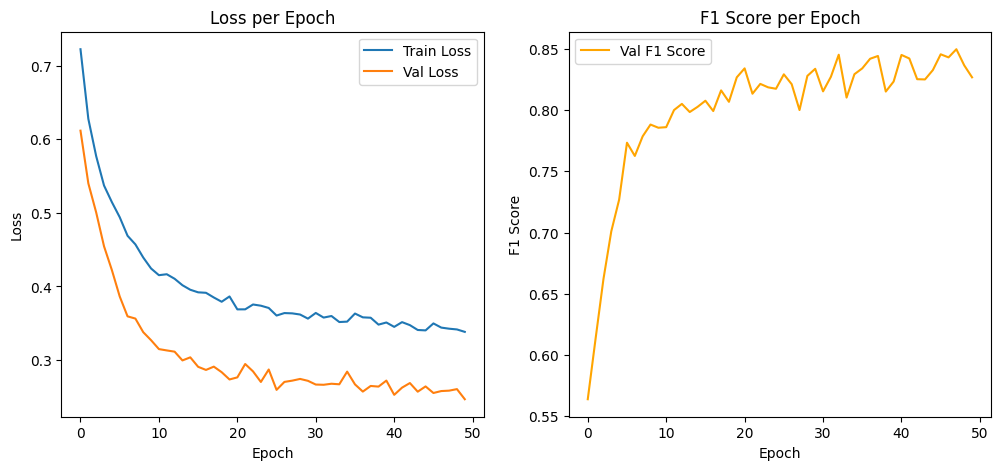

In [55]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=50,
    save_path=os.path.join(saved_models_dir, "cnn1_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE    ryan-to-linus: FAKE
  ryan-original: FAKE margot-to-taylor: FAKE
                         ryan-to-biden: FAKE
                        margot-to-ryan: FAKE
                       margot-to-biden: FAKE
                       margot-to-linus: FAKE
                       margot-to-obama: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-trump: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                        margot-to-musk: FAKE
                       margot-to-trump: FAKE
                         ryan-to-obama: FAKE


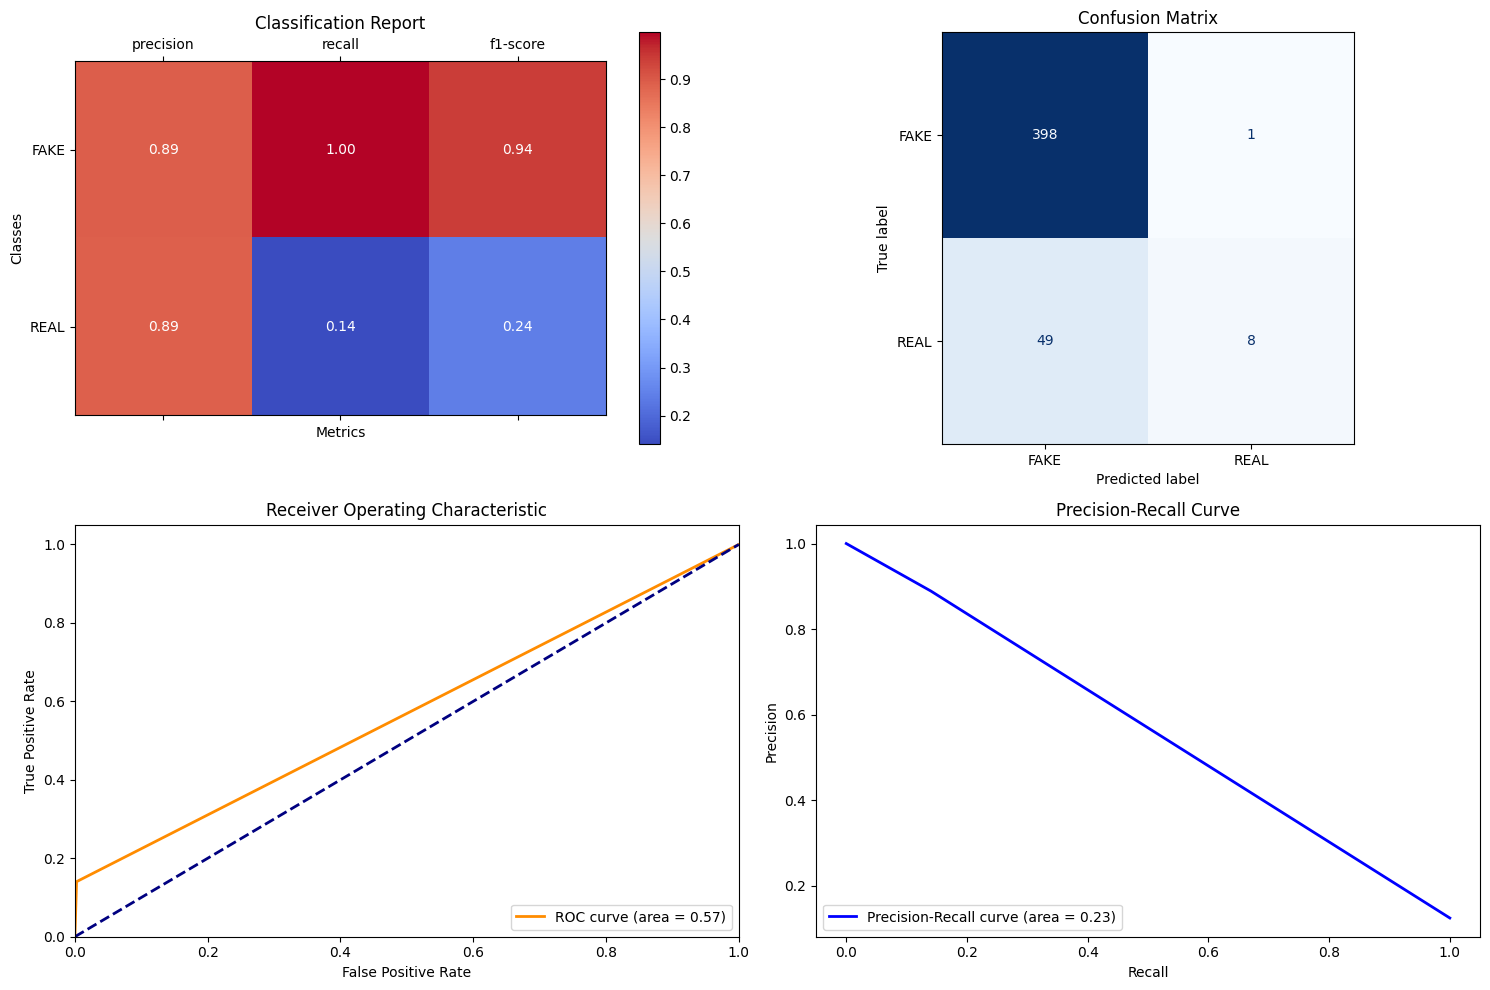

In [56]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn1_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

In [57]:
# Define model
model = audio_features_cnn.AudioFeatureCNN2().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 26]             128
              ReLU-2               [-1, 32, 26]               0
         MaxPool1d-3               [-1, 32, 13]               0
            Conv1d-4               [-1, 64, 13]           6,208
              ReLU-5               [-1, 64, 13]               0
         MaxPool1d-6                [-1, 64, 6]               0
            Conv1d-7               [-1, 128, 6]          24,704
              ReLU-8               [-1, 128, 6]               0
         MaxPool1d-9               [-1, 128, 3]               0
          Flatten-10                  [-1, 384]               0
           Linear-11                  [-1, 192]          73,920
             ReLU-12                  [-1, 192]               0
          Dropout-13                  [-1, 192]               0
           Linear-14                   

Epoch 1/50, Train Loss: 0.7431, Train Acc: 0.7624, Val Loss: 0.6508, Val Acc: 0.8011, Val Precision: 0.5723, Val Recall: 0.4160, Val F1: 0.4818
Model saved at epoch 1
Epoch 2/50, Train Loss: 0.6446, Train Acc: 0.7840, Val Loss: 0.6009, Val Acc: 0.7862, Val Precision: 0.5162, Val Recall: 0.6008, Val F1: 0.5553
Model saved at epoch 2
Epoch 3/50, Train Loss: 0.5913, Train Acc: 0.8170, Val Loss: 0.5566, Val Acc: 0.8441, Val Precision: 0.7029, Val Recall: 0.5168, Val F1: 0.5956
Model saved at epoch 3
Epoch 4/50, Train Loss: 0.5387, Train Acc: 0.8368, Val Loss: 0.5024, Val Acc: 0.8665, Val Precision: 0.7811, Val Recall: 0.5546, Val F1: 0.6486
Model saved at epoch 4
Epoch 5/50, Train Loss: 0.4919, Train Acc: 0.8579, Val Loss: 0.4743, Val Acc: 0.8842, Val Precision: 0.8800, Val Recall: 0.5546, Val F1: 0.6804
Model saved at epoch 5
Epoch 6/50, Train Loss: 0.4495, Train Acc: 0.8732, Val Loss: 0.4112, Val Acc: 0.8870, Val Precision: 0.7721, Val Recall: 0.6975, Val F1: 0.7329
Model saved at epoch 

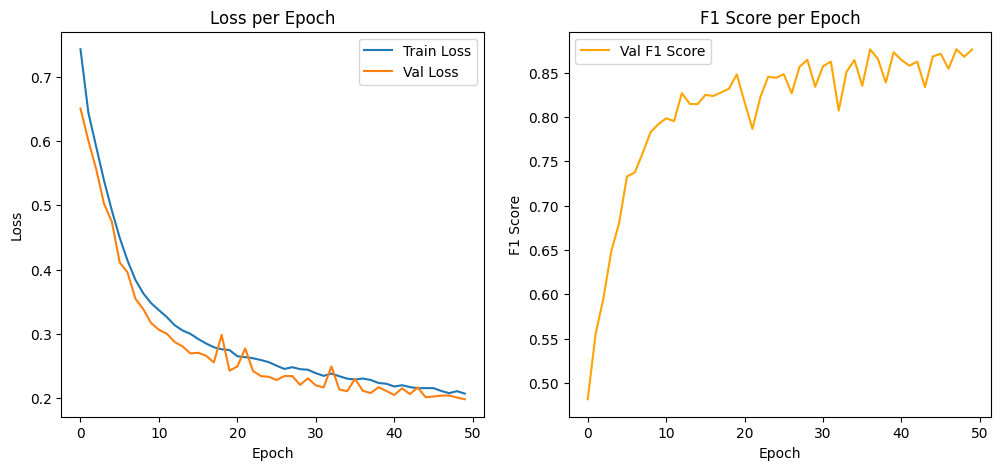

In [58]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=50,
    save_path=os.path.join(saved_models_dir, "cnn2_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE    ryan-to-obama: FAKE
  ryan-original: FAKE   ryan-to-taylor: FAKE
                       margot-to-obama: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-margot: FAKE
                       margot-to-trump: FAKE
                         ryan-to-biden: FAKE
                      margot-to-taylor: FAKE
                       margot-to-linus: FAKE
                        margot-to-ryan: FAKE
                        margot-to-musk: FAKE
                         ryan-to-trump: FAKE
                       margot-to-biden: FAKE
                          ryan-to-musk: FAKE


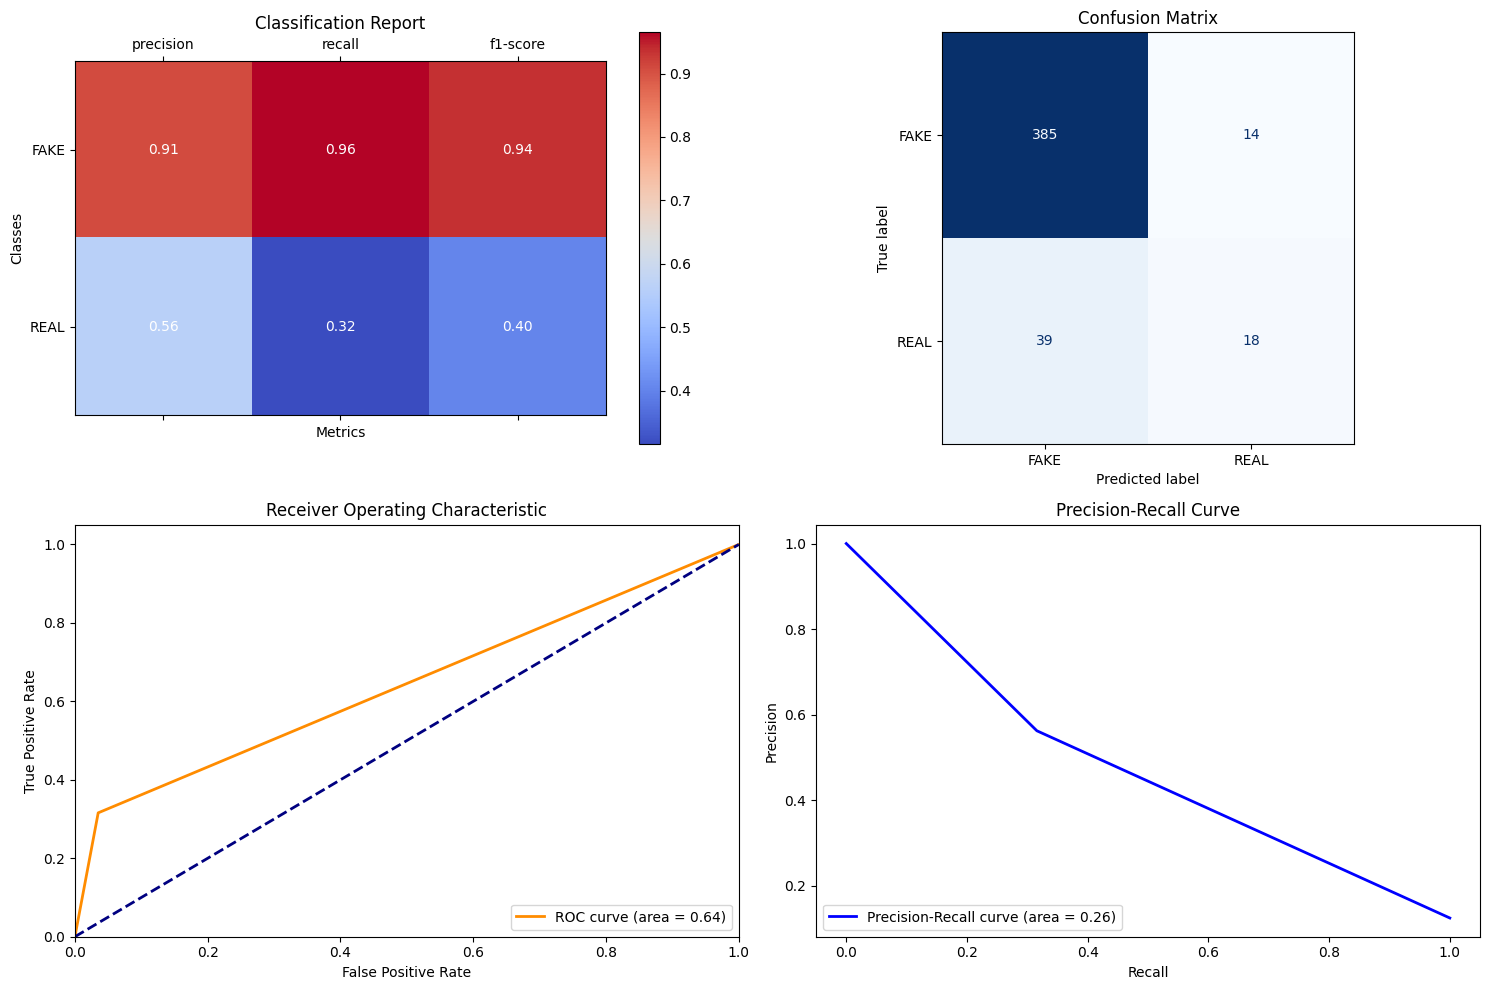

In [59]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn2_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

In [60]:
# Define model
model = audio_features_cnn.AudioFeatureCNN3().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 26]             128
              ReLU-2               [-1, 32, 26]               0
         MaxPool1d-3               [-1, 32, 13]               0
            Conv1d-4               [-1, 16, 13]           1,552
              ReLU-5               [-1, 16, 13]               0
         MaxPool1d-6                [-1, 16, 6]               0
            Conv1d-7                 [-1, 8, 6]             392
              ReLU-8                 [-1, 8, 6]               0
         MaxPool1d-9                 [-1, 8, 3]               0
          Flatten-10                   [-1, 24]               0
           Linear-11                   [-1, 12]             300
             ReLU-12                   [-1, 12]               0
           Linear-13                    [-1, 1]              13
Total params: 2,385
Trainable params: 2

Epoch 1/30, Train Loss: 0.6832, Train Acc: 0.8007, Val Loss: 0.5964, Val Acc: 0.7535, Val Precision: 0.4639, Val Recall: 0.7017, Val F1: 0.5585
Model saved at epoch 1
Epoch 2/30, Train Loss: 0.5422, Train Acc: 0.8263, Val Loss: 0.5046, Val Acc: 0.8562, Val Precision: 0.7188, Val Recall: 0.5798, Val F1: 0.6419
Model saved at epoch 2
Epoch 3/30, Train Loss: 0.4815, Train Acc: 0.8516, Val Loss: 0.4630, Val Acc: 0.8347, Val Precision: 0.5993, Val Recall: 0.7731, Val F1: 0.6752
Model saved at epoch 3
Epoch 4/30, Train Loss: 0.4395, Train Acc: 0.8656, Val Loss: 0.4147, Val Acc: 0.8824, Val Precision: 0.7745, Val Recall: 0.6639, Val F1: 0.7149
Model saved at epoch 4
Epoch 5/30, Train Loss: 0.4041, Train Acc: 0.8779, Val Loss: 0.3931, Val Acc: 0.8665, Val Precision: 0.6537, Val Recall: 0.8487, Val F1: 0.7386
Model saved at epoch 5
Epoch 6/30, Train Loss: 0.3829, Train Acc: 0.8828, Val Loss: 0.3717, Val Acc: 0.8870, Val Precision: 0.7555, Val Recall: 0.7269, Val F1: 0.7409
Model saved at epoch 

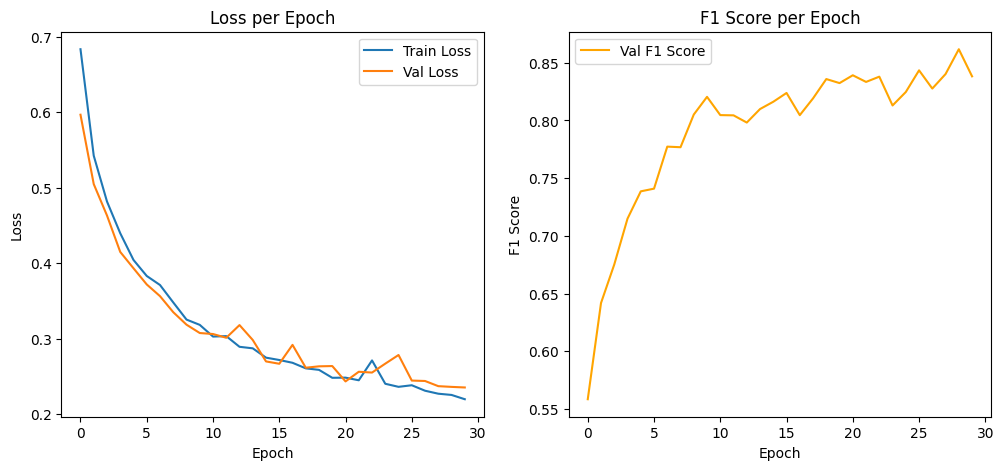

In [61]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=30,
    save_path=os.path.join(saved_models_dir, "cnn3_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: FAKE  margot-to-trump: FAKE
margot-original: FAKE margot-to-taylor: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-obama: FAKE
                       margot-to-linus: FAKE
                         ryan-to-biden: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-taylor: FAKE
                       margot-to-biden: FAKE
                        margot-to-ryan: FAKE
                       margot-to-obama: FAKE
                        ryan-to-margot: FAKE
                        margot-to-musk: FAKE


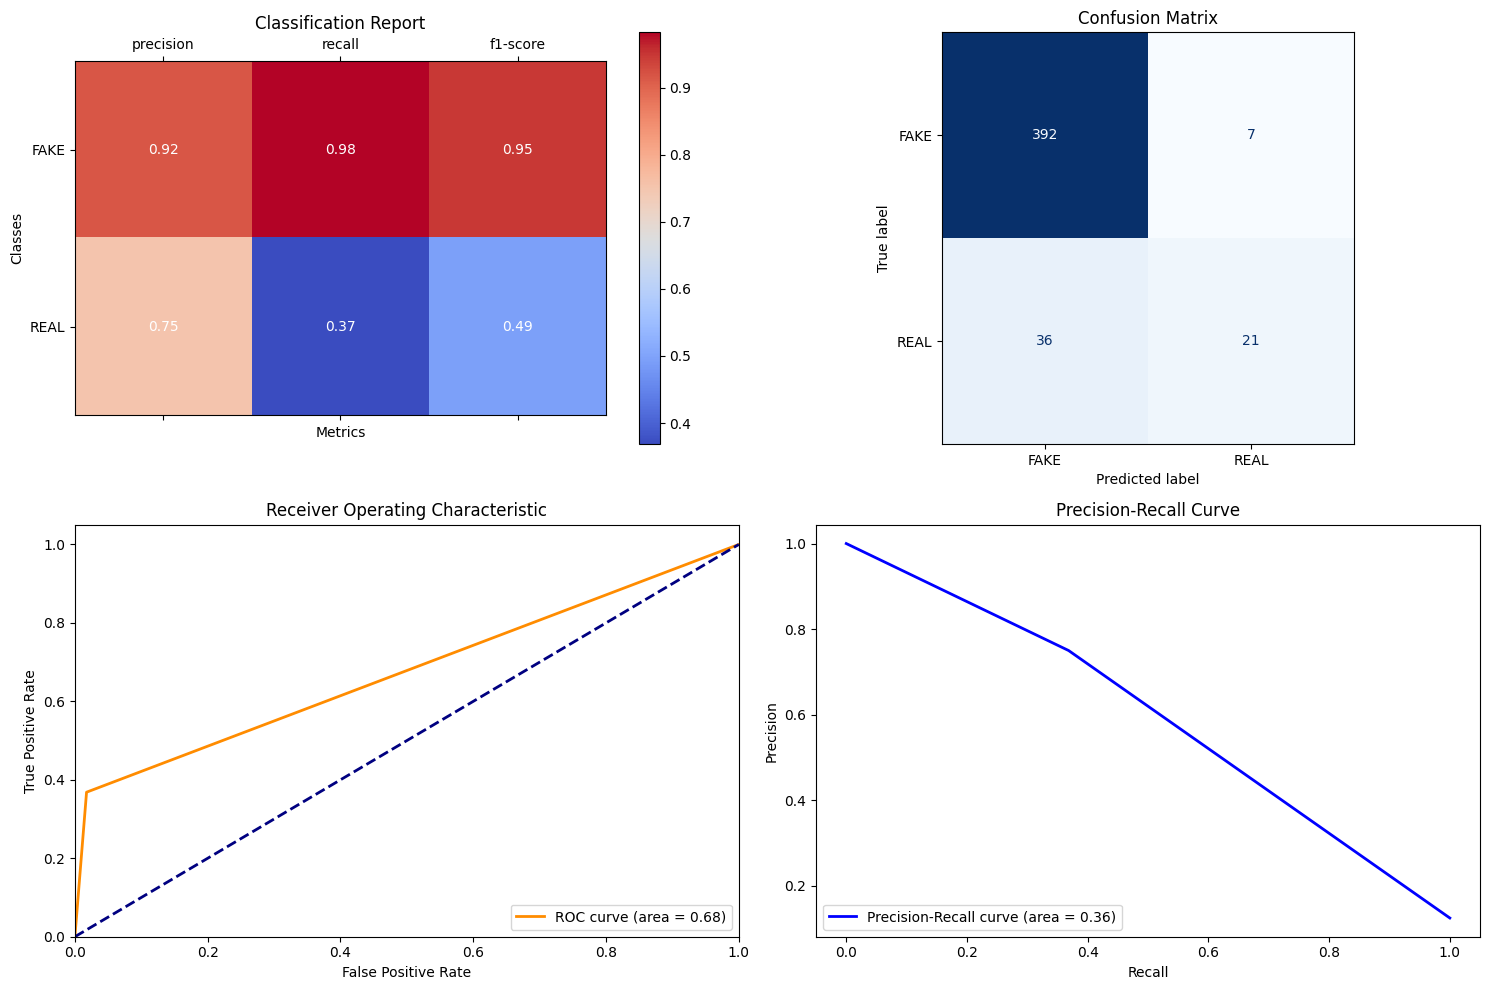

In [62]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn3_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

### With Melgrams

#### CNN

- in_channels: how many features are we passing in. Our features are our colour bands, in greyscale, we have 1 feature, in colour, we have 3 channels. <br>
- out_channels: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network. <br>
- kernel_size: the size of the kernel. Common sizes are 3x3, 5x5, 7x7. <br>
- stride: the "step-size" of the kernel. <br>
- padding: the number of pixels we should pad to the outside of the image so we can get edge pixels. <br>

**Setting padding = kernel_size // 2 will always result in an output the same shape as the input.**

In [63]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 0.9455, Train Acc: 0.7075, Val Loss: 0.6968, Val Acc: 0.7908, Val Precision: 0.5565, Val Recall: 0.2899, Val F1: 0.3812
Model saved at epoch 1
Epoch 2/20, Train Loss: 0.6613, Train Acc: 0.7689, Val Loss: 0.5681, Val Acc: 0.8469, Val Precision: 0.7534, Val Recall: 0.4622, Val F1: 0.5729
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.6158, Train Acc: 0.7798, Val Loss: 0.6035, Val Acc: 0.7722, Val Precision: 0.4899, Val Recall: 0.6092, Val F1: 0.5431
Epoch 4/20, Train Loss: 0.5728, Train Acc: 0.8044, Val Loss: 0.4766, Val Acc: 0.8590, Val Precision: 0.7919, Val Recall: 0.4958, Val F1: 0.6098
Model saved at epoch 4
Epoch 5/20, Train Loss: 0.5070, Train Acc: 0.8231, Val Loss: 0.4663, Val Acc: 0.8655, Val Precision: 0.8264, Val Recall: 0.5000, Val F1: 0.6230
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.4981, Train Acc: 0.8247, Val Loss: 0.4702, Val Acc: 0.8627, Val Precision: 0.7022, Val Recall: 0.6639, Val F1: 0.6825
Model saved at epoch 6
Epoch 7/20, Train Los

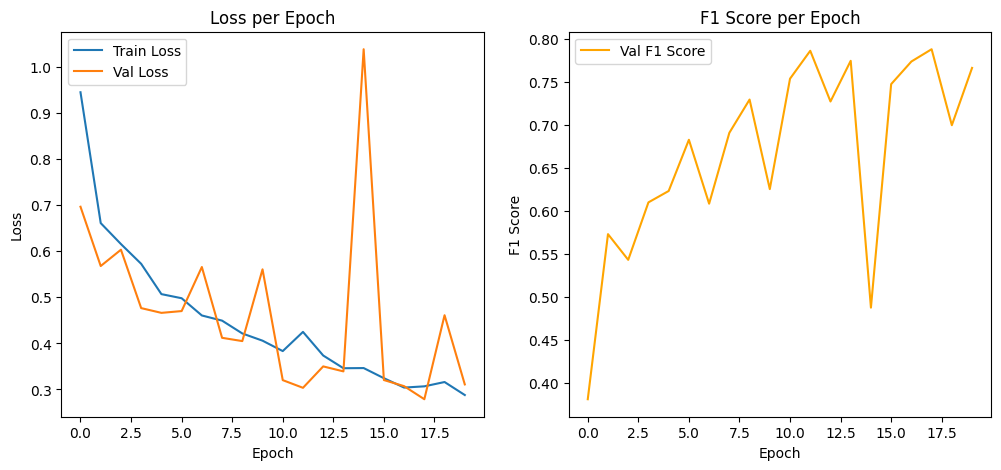

In [64]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn1_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL  margot-to-obama: FAKE
margot-original: REAL  margot-to-linus: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-trump: FAKE
                        margot-to-musk: FAKE
                       margot-to-trump: FAKE
                       margot-to-biden: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-obama: FAKE
                         ryan-to-linus: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-biden: FAKE
                        margot-to-ryan: FAKE


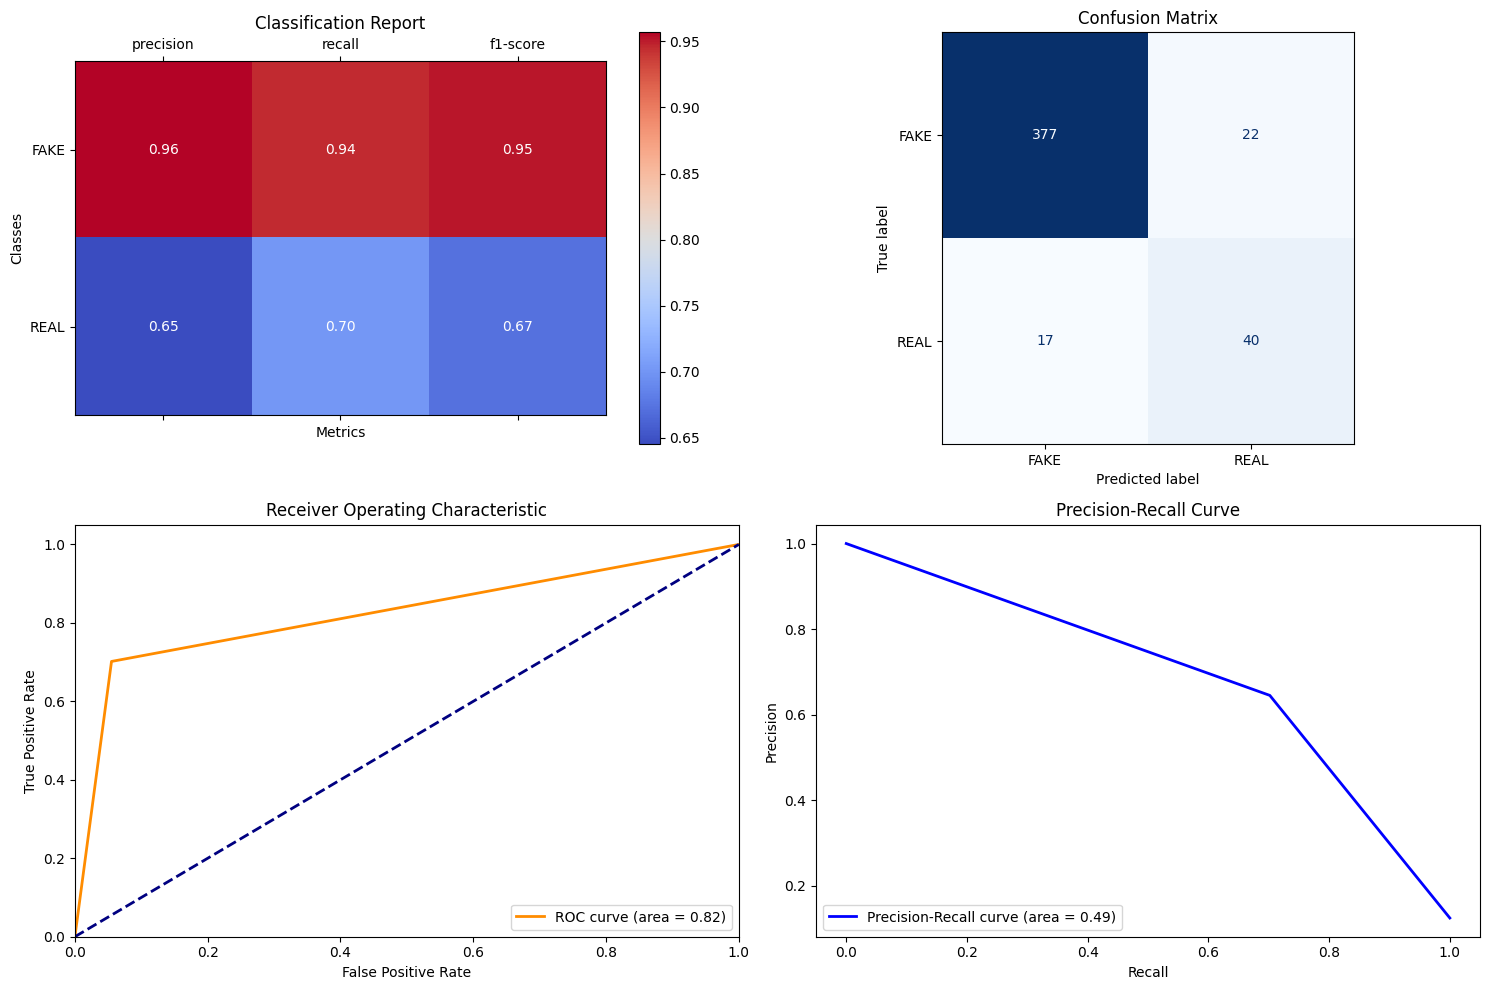

In [65]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn1_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [66]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 0.7840, Train Acc: 0.7364, Val Loss: 0.7538, Val Acc: 0.7815, Val Precision: 0.5256, Val Recall: 0.1723, Val F1: 0.2595
Model saved at epoch 1
Epoch 2/20, Train Loss: 0.7317, Train Acc: 0.7582, Val Loss: 0.6996, Val Acc: 0.8151, Val Precision: 0.6923, Val Recall: 0.3025, Val F1: 0.4211
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.6757, Train Acc: 0.7675, Val Loss: 0.6581, Val Acc: 0.7572, Val Precision: 0.4652, Val Recall: 0.6176, Val F1: 0.5307
Model saved at epoch 3
Epoch 4/20, Train Loss: 0.6289, Train Acc: 0.7780, Val Loss: 0.6499, Val Acc: 0.7124, Val Precision: 0.4178, Val Recall: 0.7479, Val F1: 0.5361
Model saved at epoch 4
Epoch 5/20, Train Loss: 0.5954, Train Acc: 0.7851, Val Loss: 0.8128, Val Acc: 0.4697, Val Precision: 0.2943, Val Recall: 0.9916, Val F1: 0.4538
Epoch 6/20, Train Loss: 0.5939, Train Acc: 0.7806, Val Loss: 0.7441, Val Acc: 0.5425, Val Precision: 0.3136, Val Recall: 0.8908, Val F1: 0.4639
Epoch 7/20, Train Loss: 0.5593, Train Acc: 0

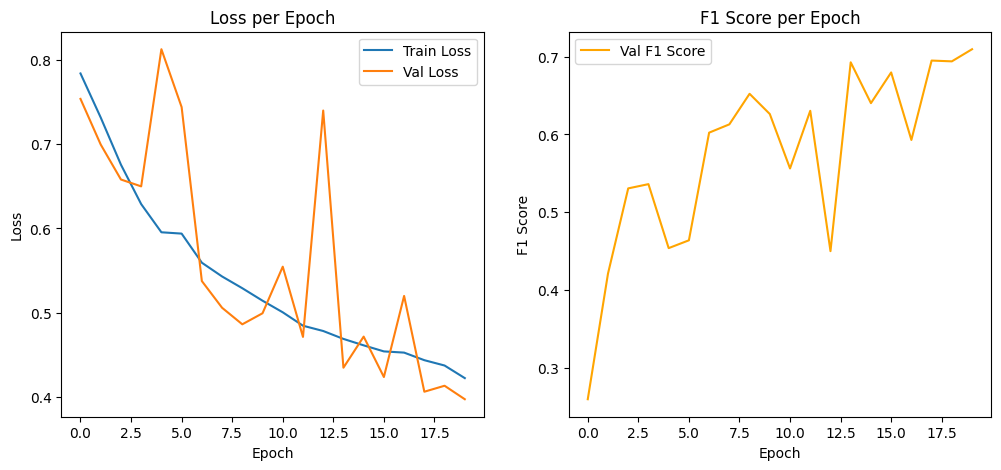

In [67]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.5,
    weight_decay=0.0001,
)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn2_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL  margot-to-obama: FAKE
margot-original: FAKE     ryan-to-musk: FAKE
                         ryan-to-biden: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-linus: FAKE
                       margot-to-linus: FAKE
                      margot-to-taylor: FAKE
                        margot-to-ryan: FAKE
                        ryan-to-margot: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE
                        margot-to-musk: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-obama: FAKE


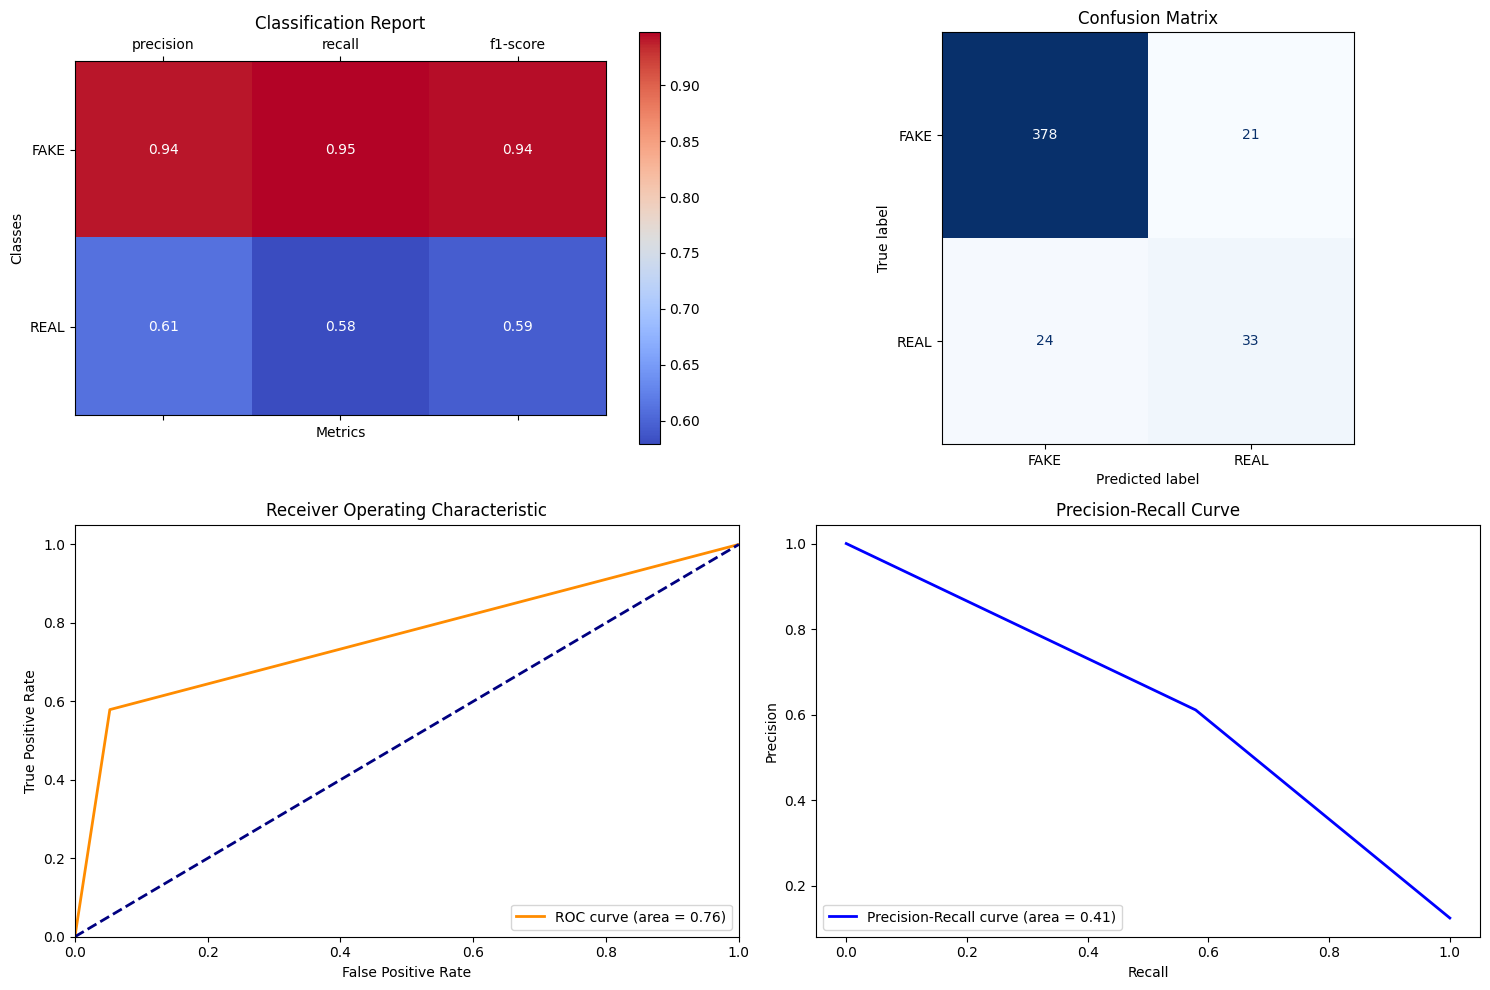

In [68]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn2_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [69]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 1.0432, Train Acc: 0.7253, Val Loss: 0.7260, Val Acc: 0.7759, Val Precision: 0.4931, Val Recall: 0.2983, Val F1: 0.3717
Model saved at epoch 1
Epoch 2/20, Train Loss: 0.6987, Train Acc: 0.7613, Val Loss: 0.6107, Val Acc: 0.8217, Val Precision: 0.7582, Val Recall: 0.2899, Val F1: 0.4195
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.5979, Train Acc: 0.7906, Val Loss: 0.6238, Val Acc: 0.8170, Val Precision: 0.6312, Val Recall: 0.4244, Val F1: 0.5075
Model saved at epoch 3
Epoch 4/20, Train Loss: 0.5717, Train Acc: 0.8048, Val Loss: 0.4600, Val Acc: 0.8310, Val Precision: 0.5947, Val Recall: 0.7521, Val F1: 0.6642
Model saved at epoch 4
Epoch 5/20, Train Loss: 0.5322, Train Acc: 0.8042, Val Loss: 0.4634, Val Acc: 0.8375, Val Precision: 0.6074, Val Recall: 0.7605, Val F1: 0.6754
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.5333, Train Acc: 0.8085, Val Loss: 0.5049, Val Acc: 0.8385, Val Precision: 0.6738, Val Recall: 0.5294, Val F1: 0.5929
Epoch 7/20, Train Los

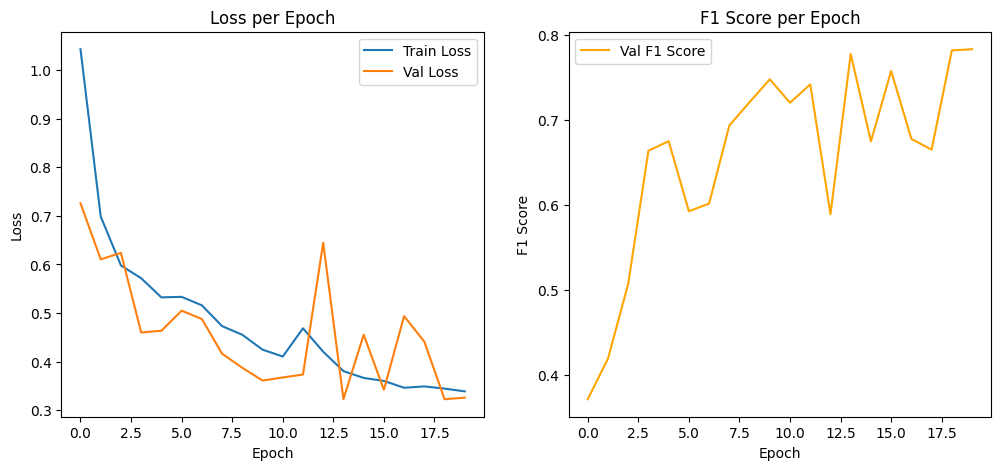

In [70]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn3_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: REAL  margot-to-linus: FAKE
  ryan-original: REAL   margot-to-musk: FAKE
                      margot-to-taylor: FAKE
                       margot-to-trump: FAKE
                         ryan-to-trump: FAKE
                        ryan-to-margot: FAKE
                         ryan-to-biden: FAKE
                        margot-to-ryan: FAKE
                       margot-to-obama: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-obama: FAKE
                       margot-to-biden: FAKE


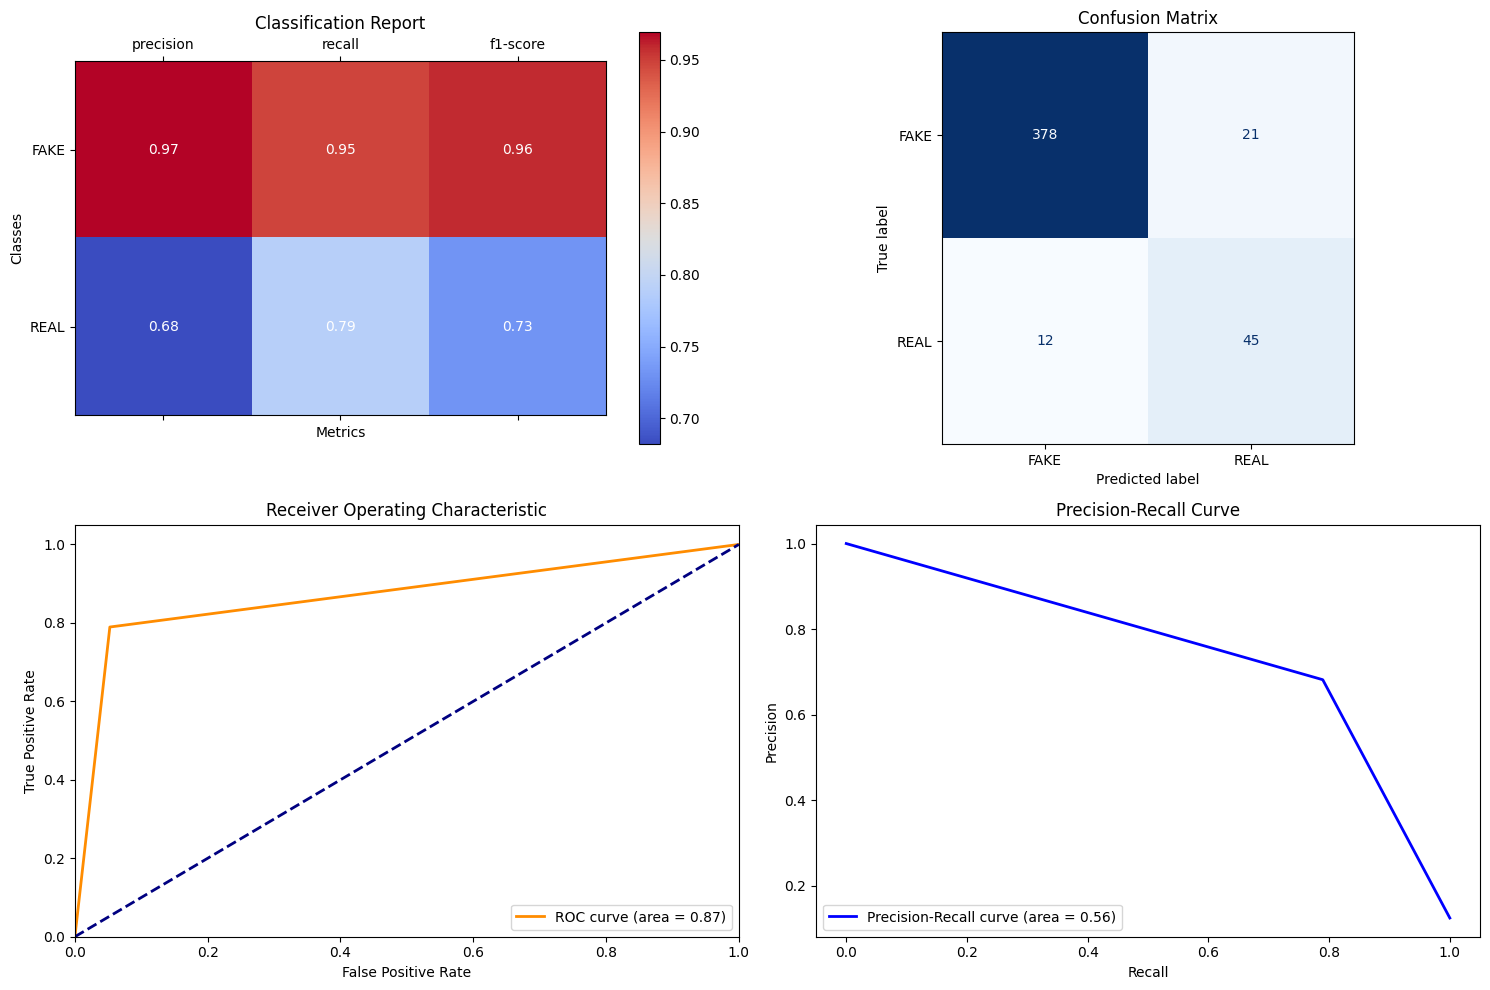

In [71]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn3_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [72]:
# Define model
model = melgram_cnn.MelgramCNN2().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

Epoch 1/20, Train Loss: 1.2675, Train Acc: 0.7042, Val Loss: 0.7785, Val Acc: 0.7787, Val Precision: 1.0000, Val Recall: 0.0042, Val F1: 0.0084
Model saved at epoch 1
Epoch 2/20, Train Loss: 0.7634, Train Acc: 0.7565, Val Loss: 0.6895, Val Acc: 0.7274, Val Precision: 0.4000, Val Recall: 0.4538, Val F1: 0.4252
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.6734, Train Acc: 0.7762, Val Loss: 0.6321, Val Acc: 0.8189, Val Precision: 0.8235, Val Recall: 0.2353, Val F1: 0.3660
Epoch 4/20, Train Loss: 0.6383, Train Acc: 0.7866, Val Loss: 0.5667, Val Acc: 0.8123, Val Precision: 0.6045, Val Recall: 0.4496, Val F1: 0.5157
Model saved at epoch 4
Epoch 5/20, Train Loss: 0.6169, Train Acc: 0.7937, Val Loss: 0.6425, Val Acc: 0.8310, Val Precision: 0.8608, Val Recall: 0.2857, Val F1: 0.4290
Epoch 6/20, Train Loss: 0.6765, Train Acc: 0.7901, Val Loss: 0.5781, Val Acc: 0.7852, Val Precision: 0.5220, Val Recall: 0.3992, Val F1: 0.4524
Epoch 7/20, Train Loss: 0.5780, Train Acc: 0.7999, Val Loss: 0.5074

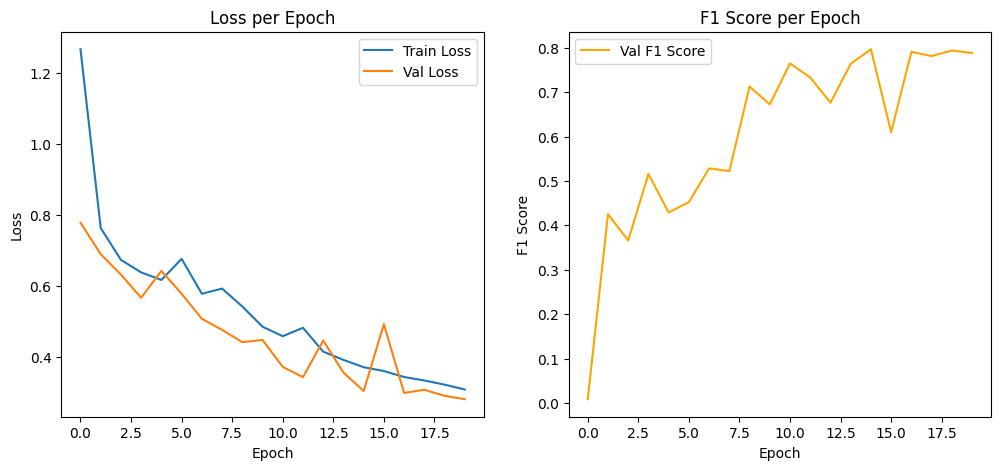

In [73]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn4_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: FAKE  margot-to-linus: FAKE
margot-original: REAL     ryan-to-musk: FAKE
                         ryan-to-obama: FAKE
                         ryan-to-trump: FAKE
                      margot-to-taylor: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE
                         ryan-to-biden: FAKE
                        margot-to-ryan: FAKE
                         ryan-to-linus: FAKE
                        margot-to-musk: FAKE
                       margot-to-obama: FAKE
                        ryan-to-margot: FAKE
                        ryan-to-taylor: FAKE


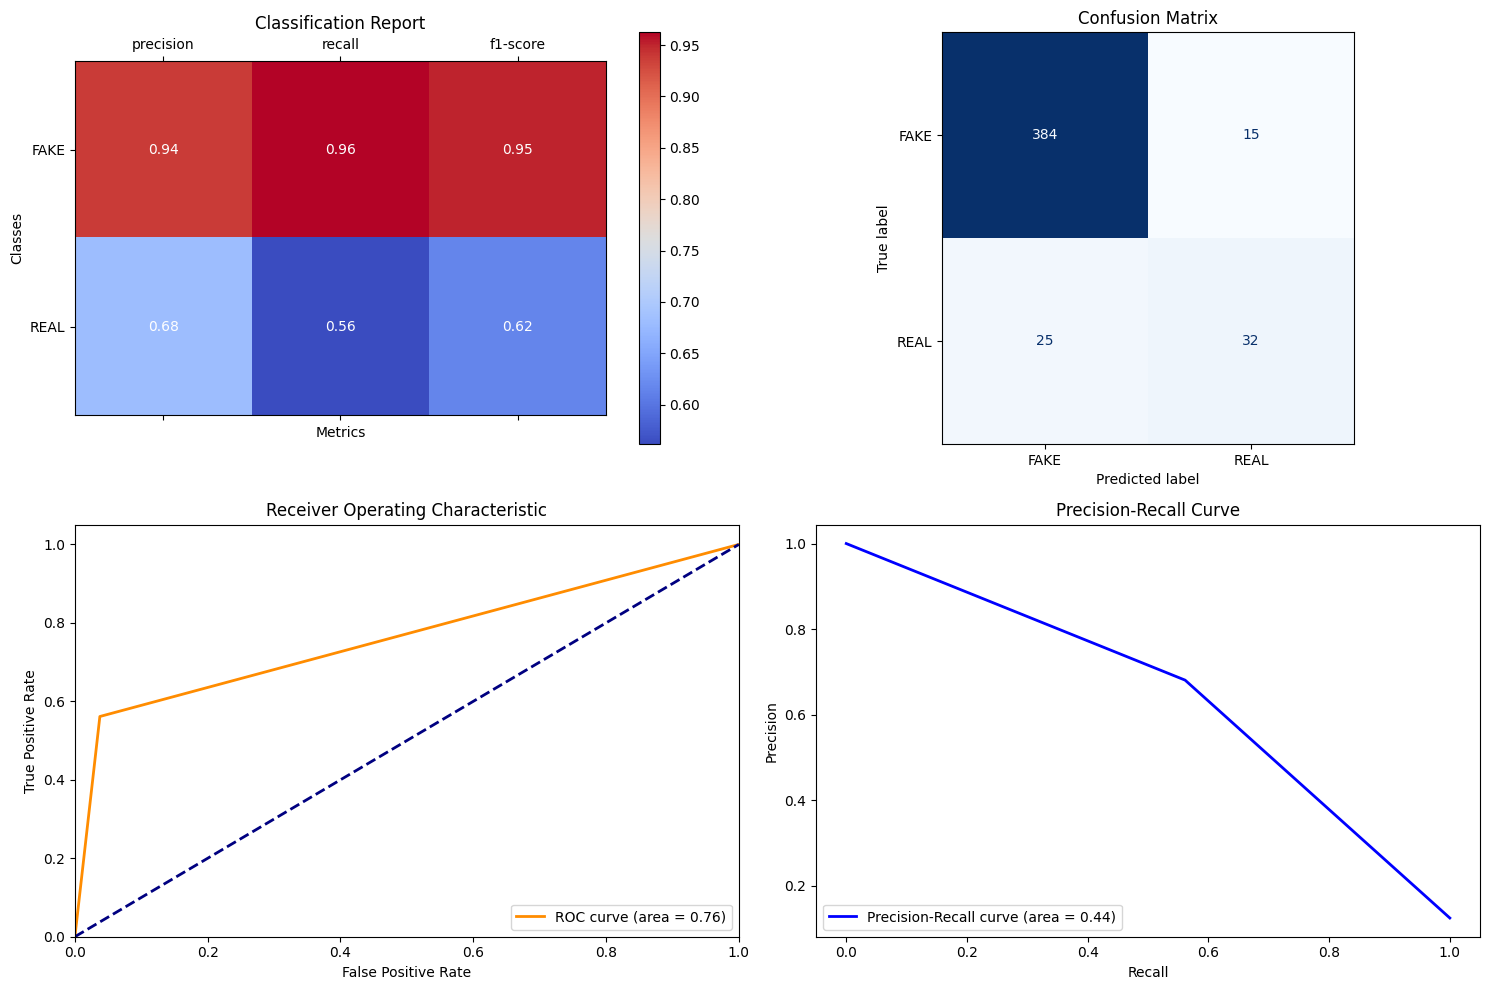

In [74]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn4_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [75]:
# Define model
model = melgram_cnn.MelgramCNN2().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

Epoch 1/20, Train Loss: 0.7908, Train Acc: 0.7312, Val Loss: 0.7616, Val Acc: 0.7778, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 2/20, Train Loss: 0.7533, Train Acc: 0.7465, Val Loss: 0.7236, Val Acc: 0.8123, Val Precision: 0.8936, Val Recall: 0.1765, Val F1: 0.2947
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.7126, Train Acc: 0.7525, Val Loss: 0.7069, Val Acc: 0.7666, Val Precision: 0.4774, Val Recall: 0.5336, Val F1: 0.5040
Model saved at epoch 3
Epoch 4/20, Train Loss: 0.6645, Train Acc: 0.7730, Val Loss: 0.6523, Val Acc: 0.7834, Val Precision: 0.5110, Val Recall: 0.5840, Val F1: 0.5451
Model saved at epoch 4
Epoch 5/20, Train Loss: 0.6295, Train Acc: 0.7816, Val Loss: 0.5724, Val Acc: 0.8394, Val Precision: 0.7143, Val Recall: 0.4622, Val F1: 0.5612
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.5959, Train Acc: 0.7828, Val Loss: 0.5503, Val Acc: 0.8375, Val Precision: 0.6569, Val Recall: 0.5630, Val F1: 0.6063
Model saved at epoch 6
Epoch 7/20, Train Los

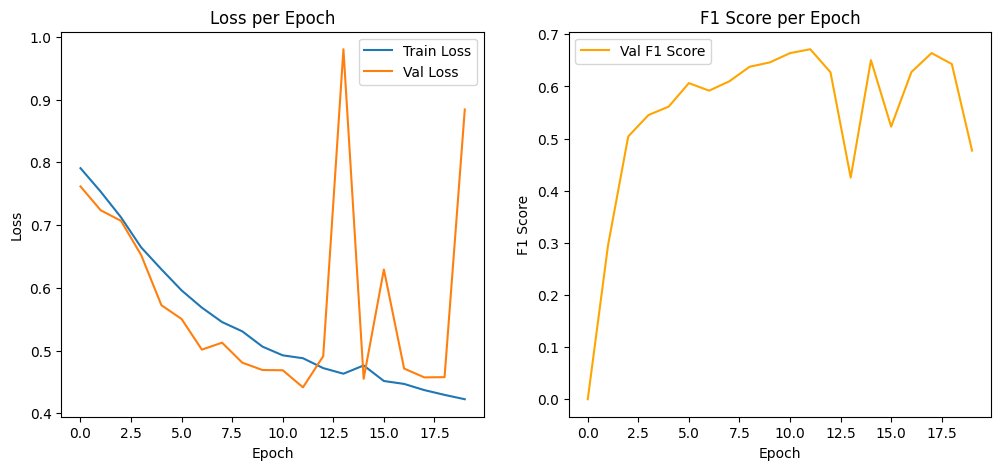

In [76]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.5,
    weight_decay=0.0001,
)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn5_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE    ryan-to-trump: FAKE
  ryan-original: REAL  margot-to-obama: FAKE
                         ryan-to-biden: FAKE
                       margot-to-linus: FAKE
                        margot-to-musk: FAKE
                         ryan-to-obama: FAKE
                      margot-to-taylor: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE
                        ryan-to-taylor: FAKE
                        margot-to-ryan: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-linus: FAKE


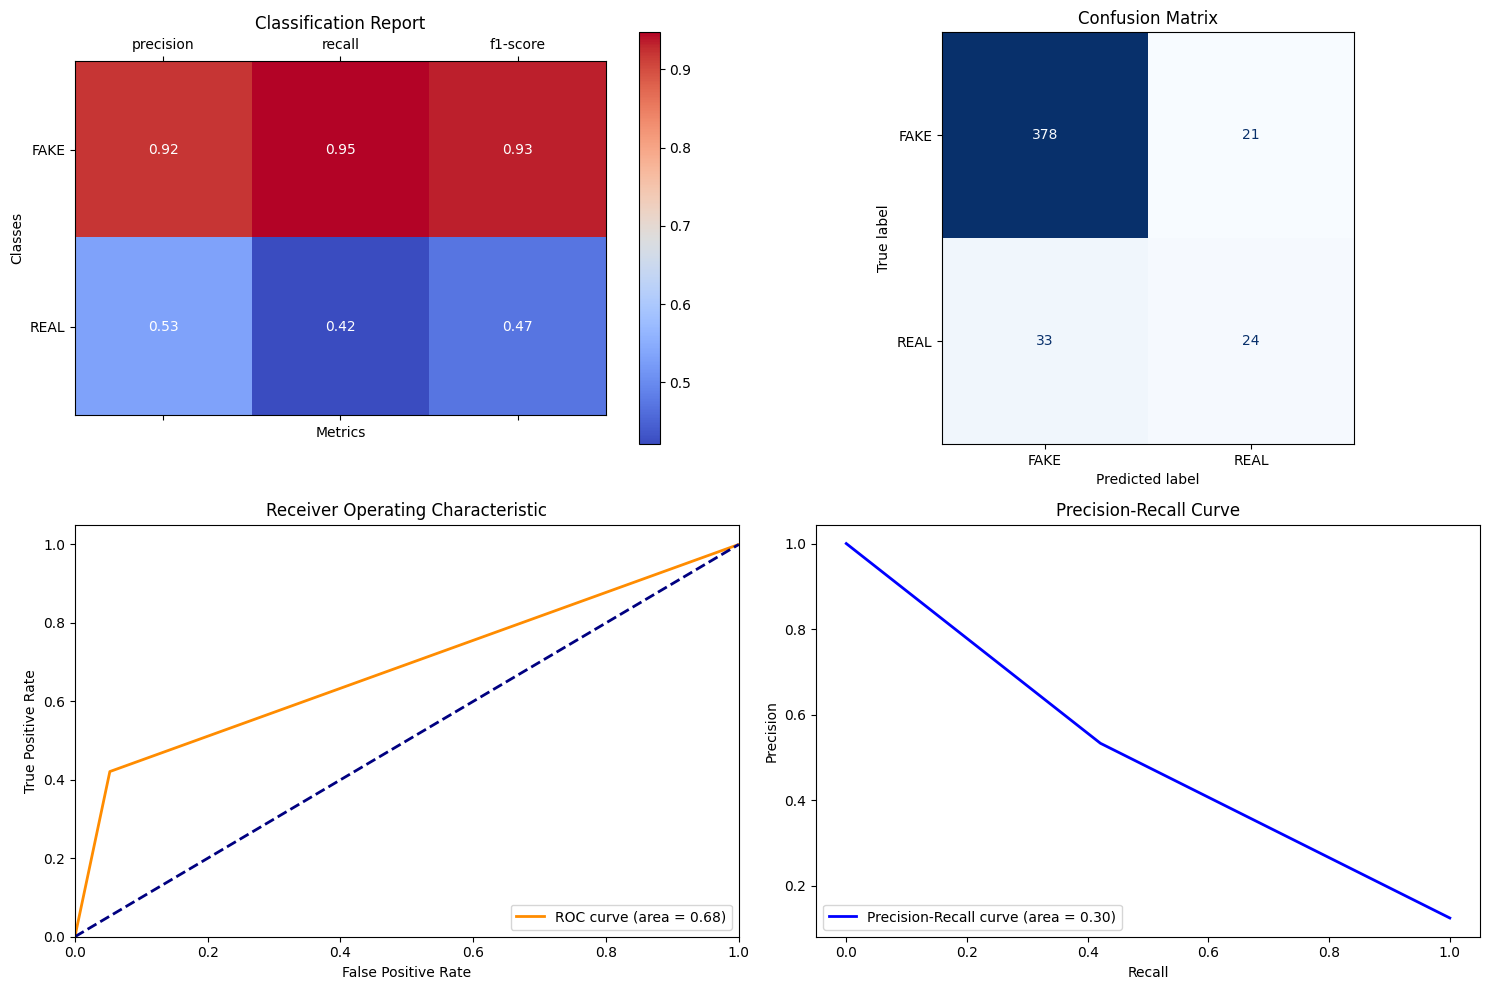

In [77]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn5_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

#### Resnet - Transfer Learning
Information about the fine tuning can be found [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [78]:
class ResNetForAudio(nn.Module):
    def __init__(self, model):
        super(ResNetForAudio, self).__init__()
        self.model = model
        self.model.conv1 = nn.Conv2d(
            1,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,  # change input layer for pickle files
        )
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x)


model = ResNetForAudio(models.resnet18(weights="IMAGENET1K_V1")).to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [80]:
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9,
)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/15, Train Loss: 0.6722, Train Acc: 0.7639, Val Loss: 0.6274, Val Acc: 0.7722, Val Precision: 0.4864, Val Recall: 0.4496, Val F1: 0.4672
Model saved at epoch 1
Epoch 2/15, Train Loss: 0.5607, Train Acc: 0.8070, Val Loss: 0.5696, Val Acc: 0.7787, Val Precision: 0.5013, Val Recall: 0.7941, Val F1: 0.6146
Model saved at epoch 2
Epoch 3/15, Train Loss: 0.4982, Train Acc: 0.8229, Val Loss: 0.4738, Val Acc: 0.8441, Val Precision: 0.6263, Val Recall: 0.7395, Val F1: 0.6782
Model saved at epoch 3
Epoch 4/15, Train Loss: 0.4337, Train Acc: 0.8541, Val Loss: 0.4597, Val Acc: 0.8273, Val Precision: 0.5852, Val Recall: 0.7647, Val F1: 0.6630
Epoch 5/15, Train Loss: 0.4018, Train Acc: 0.8637, Val Loss: 0.4129, Val Acc: 0.8674, Val Precision: 0.6832, Val Recall: 0.7521, Val F1: 0.7160
Model saved at epoch 5
Epoch 6/15, Train Loss: 0.3662, Train Acc: 0.8801, Val Loss: 0.3963, Val Acc: 0.8562, Val Precision: 0.6391, Val Recall: 0.8109, Val F1: 0.7148
Epoch 7/15, Train Loss: 0.3287, Train Acc: 0

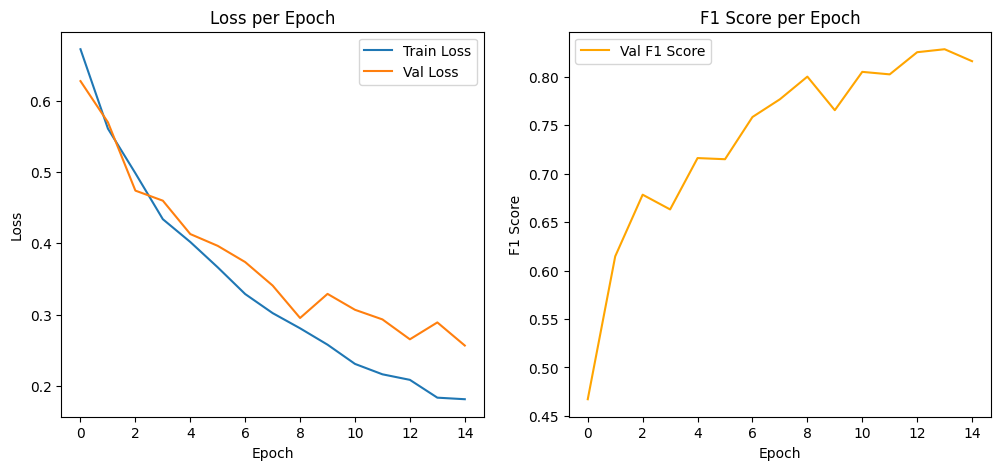

In [81]:
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=15,
    save_path=os.path.join(saved_models_dir, "pretrained_resnet.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL     ryan-to-musk: FAKE
margot-original: REAL   ryan-to-margot: FAKE
                       margot-to-biden: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-biden: FAKE
                       margot-to-trump: FAKE
                       margot-to-obama: FAKE
                         ryan-to-trump: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-obama: FAKE
                        margot-to-ryan: FAKE
                        ryan-to-taylor: FAKE
                        margot-to-musk: FAKE
                       margot-to-linus: FAKE


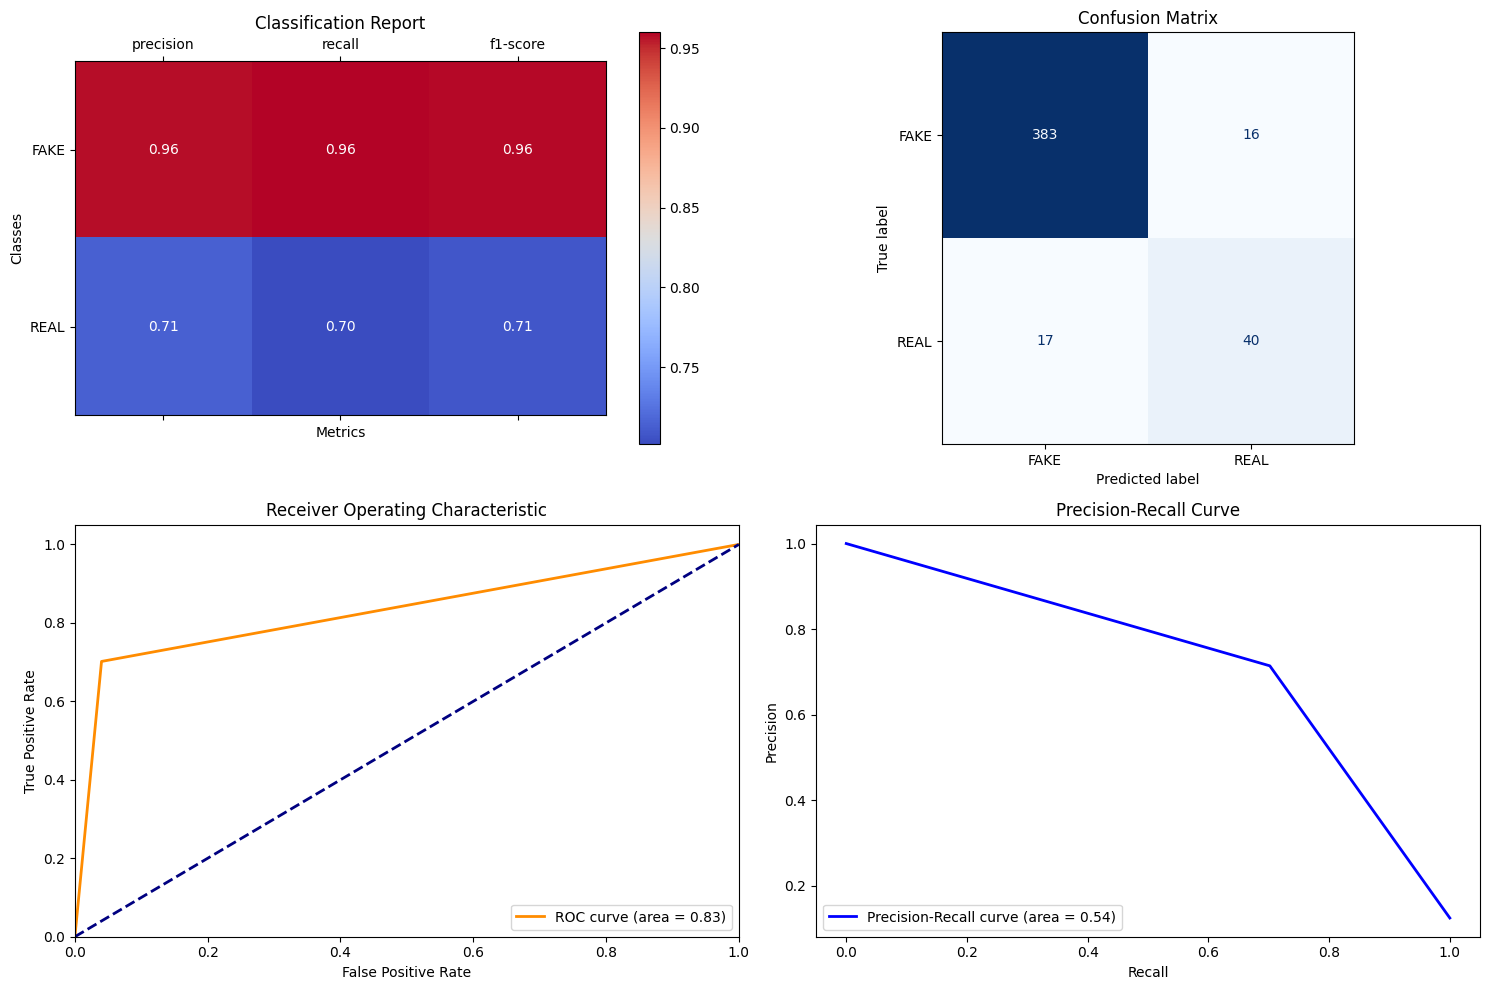

In [82]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "pretrained_resnet.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [83]:
model = ResNetForAudio(models.resnet34(weights="IMAGENET1K_V1")).to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [84]:
class_weights = torch.tensor([1.0, 2.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.0001,
#     momentum=0.9,
# )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15, Train Loss: 0.6789, Train Acc: 0.7682, Val Loss: 0.9755, Val Acc: 0.7694, Val Precision: 0.4400, Val Recall: 0.1387, Val F1: 0.2109
Model saved at epoch 1
Epoch 2/15, Train Loss: 0.5397, Train Acc: 0.8034, Val Loss: 0.6273, Val Acc: 0.8422, Val Precision: 0.8350, Val Recall: 0.3613, Val F1: 0.5044
Model saved at epoch 2
Epoch 3/15, Train Loss: 0.4383, Train Acc: 0.8269, Val Loss: 0.5651, Val Acc: 0.7591, Val Precision: 0.4752, Val Recall: 0.8067, Val F1: 0.5981
Model saved at epoch 3
Epoch 4/15, Train Loss: 0.3848, Train Acc: 0.8363, Val Loss: 0.4420, Val Acc: 0.8301, Val Precision: 0.5778, Val Recall: 0.8739, Val F1: 0.6957
Model saved at epoch 4
Epoch 5/15, Train Loss: 0.3496, Train Acc: 0.8590, Val Loss: 0.2959, Val Acc: 0.8992, Val Precision: 0.7241, Val Recall: 0.8824, Val F1: 0.7955
Model saved at epoch 5
Epoch 6/15, Train Loss: 0.3028, Train Acc: 0.8887, Val Loss: 0.6162, Val Acc: 0.7796, Val Precision: 0.5026, Val Recall: 0.8151, Val F1: 0.6218
Epoch 7/15, Train Los

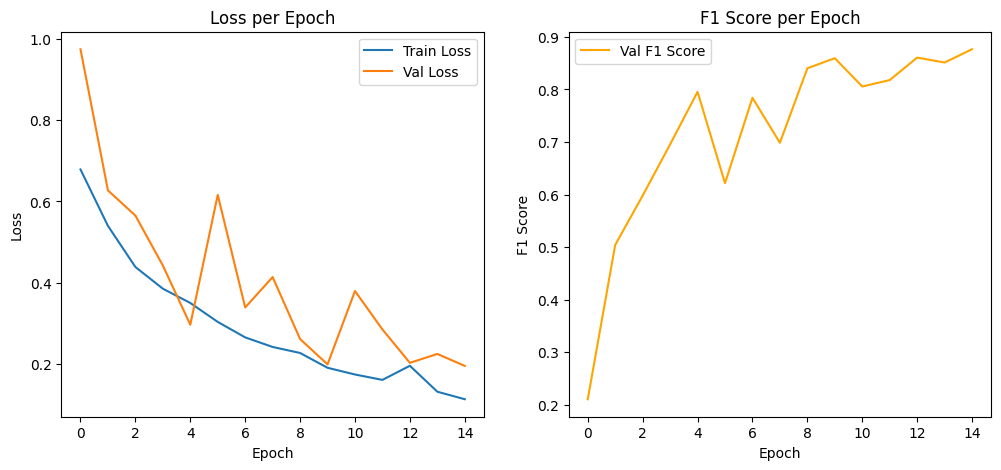

In [85]:
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=15,
    save_path=os.path.join(saved_models_dir, "pretrained_resnet2.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: REAL     ryan-to-musk: FAKE
  ryan-original: FAKE   ryan-to-margot: FAKE
                         ryan-to-obama: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-linus: FAKE
                       margot-to-biden: FAKE
                        ryan-to-taylor: FAKE
                        margot-to-ryan: FAKE
                         ryan-to-biden: FAKE
                      margot-to-taylor: FAKE
                       margot-to-trump: FAKE
                       margot-to-obama: FAKE
                        margot-to-musk: FAKE
                       margot-to-linus: FAKE


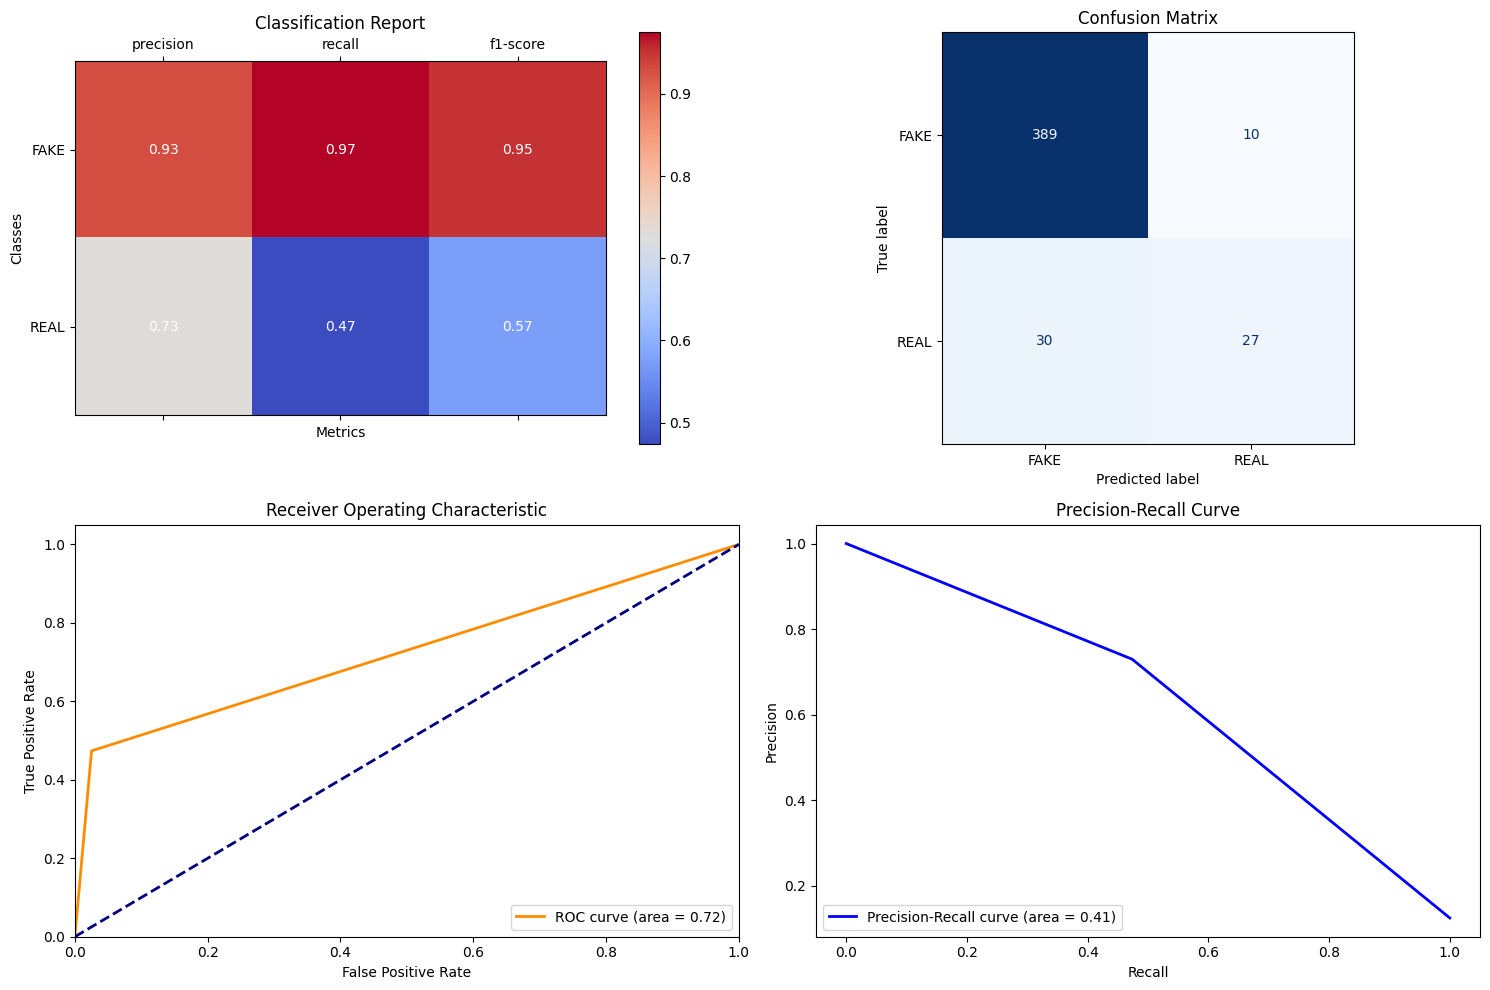

In [86]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "pretrained_resnet2.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)